In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,MinMaxScaler
from imblearn.over_sampling import SMOTE
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
import optuna
from optuna import Trial
from imblearn.combine import SMOTEENN
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import mean_squared_error

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import BorderlineSMOTE
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier , GradientBoostingClassifier , ExtraTreesClassifier , VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV , cross_val_score , StratifiedKFold , learning_curve

In [4]:
df = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_sub = pd.read_csv("sample_submission.csv")
df_ = df.copy()

# EDA

In [4]:
pd.options.display.max_info_columns
df.info(verbose=True)


pd.set_option('display.max_info_columns', 1000) 
pd.set_option('display.max_columns', 1000) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171202 entries, 0 to 171201
Data columns (total 51 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   171202 non-null  int64  
 1   TARGET                       171202 non-null  int64  
 2   NAME_CONTRACT_TYPE           171202 non-null  object 
 3   CODE_GENDER                  171202 non-null  object 
 4   FLAG_OWN_CAR                 136961 non-null  object 
 5   FLAG_OWN_REALTY              136961 non-null  object 
 6   CNT_CHILDREN                 171202 non-null  int64  
 7   AMT_INCOME_TOTAL             171202 non-null  float64
 8   AMT_CREDIT                   171202 non-null  float64
 9   AMT_ANNUITY                  171196 non-null  float64
 10  AMT_GOODS_PRICE              171039 non-null  float64
 11  NAME_TYPE_SUITE              170455 non-null  object 
 12  NAME_INCOME_TYPE             171202 non-null  object 
 13 

In [36]:
intcolumns = df_.select_dtypes("int").columns
floatcolumns = df_.select_dtypes("float").columns
df[intcolumns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171202 entries, 0 to 171201
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype
---  ------                       --------------   -----
 0   SK_ID_CURR                   171202 non-null  int64
 1   TARGET                       171202 non-null  int64
 2   CNT_CHILDREN                 171202 non-null  int64
 3   DAYS_BIRTH                   171202 non-null  int64
 4   DAYS_EMPLOYED                171202 non-null  int64
 5   DAYS_ID_PUBLISH              171202 non-null  int64
 6   FLAG_MOBIL                   171202 non-null  int64
 7   FLAG_EMP_PHONE               171202 non-null  int64
 8   FLAG_WORK_PHONE              171202 non-null  int64
 9   FLAG_CONT_MOBILE             171202 non-null  int64
 10  FLAG_PHONE                   171202 non-null  int64
 11  FLAG_EMAIL                   171202 non-null  int64
 12  REGION_RATING_CLIENT         171202 non-null  int64
 13  REGION_RATING_CLIENT_W_CITY  

In [15]:
df[floatcolumns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171202 entries, 0 to 171201
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AMT_INCOME_TOTAL            171202 non-null  float64
 1   AMT_CREDIT                  171202 non-null  float64
 2   AMT_ANNUITY                 171196 non-null  float64
 3   AMT_GOODS_PRICE             171039 non-null  float64
 4   REGION_POPULATION_RELATIVE  171202 non-null  float64
 5   DAYS_REGISTRATION           171202 non-null  float64
 6   OWN_CAR_AGE                 58210 non-null   float64
 7   CNT_FAM_MEMBERS             171200 non-null  float64
 8   EXT_SOURCE_1                52274 non-null   float64
 9   EXT_SOURCE_2                170833 non-null  float64
 10  EXT_SOURCE_3                116616 non-null  float64
 11  OBS_30_CNT_SOCIAL_CIRCLE    170642 non-null  float64
 12  DEF_30_CNT_SOCIAL_CIRCLE    170642 non-null  float64
 13  OBS_60_CNT_SOC

In [60]:
df.tail(5)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
171197      171197       0         Cash loans           M          NaN   
171198      171198       0         Cash loans           F            Y   
171199      171199       0         Cash loans           F            N   
171200      171200       0         Cash loans           M            Y   
171201      171201       0         Cash loans           F          NaN   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
171197             NaN             0           83250.0    404325.0   
171198               Y             0          247500.0    601470.0   
171199               N             2          292500.0   1237684.5   
171200               N             0          112500.0    239850.0   
171201             NaN             0          108000.0    161730.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
171197      20772.0         337500.0   Unaccompanied               Working   
171198      29065.5         450000.0   Unaccompanied               Working   
171199      49216.5        1138500.0   Unaccompanied         State servant   
171200      25186.5         225000.0   Unaccompanied  Commercial associate   
171201       8595.0         135000.0          Family               Working   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
171197  Secondary / secondary special               Married   
171198  Secondary / secondary special  Single / not married   
171199               Higher education               Married   
171200  Secondary / secondary special  Single / not married   
171201  Secondary / secondary special  Single / not married   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
171197  House / apartment                    0.031329      -20529   
171198  House / apartment                    0.010006      -22083   
171199  House / apartment                    0.006629      -11053   
171200  House / apartment                    0.009657       -8505   
171201  House / apartment                    0.007305      -17925   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
171197          -3059           -11581.0            -3689         21.0   
171198           -129            -4629.0            -1773          1.0   
171199          -2536            -4858.0            -3393          NaN   
171200           -165            -3318.0            -1176          7.0   
171201          -5209            -2411.0            -1473          NaN   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
171197           1               1                1                 1   
171198           1               1                0                 1   
171199           1               1                0                 1   
171200           1               1                0                 1   
171201           1               1                1                 1   

        FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
171197           0           0        Laborers              2.0   
171198           0           0   Cooking staff              1.0   
171199           0           1      Core staff              4.0   
171200           0           0     Sales staff              1.0   
171201           1           0      Core staff              1.0   

        REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
171197                     2                            2   
171198                     2                            1   
171199                     2                            2   
171200                     2                            2   
171201                     3                            3   

        REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
171197                           0                           0   
171198                           0                           0   
171199                     

In [61]:
df_.head(5)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           0       0         Cash loans           F            N   
1           1       0         Cash loans           F            N   
2           2       0         Cash loans           F            N   
3           3       0         Cash loans           F            N   
4           4       1         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               N             0          112500.0    755190.0      36328.5   
1               Y             0          225000.0    585000.0      16893.0   
2               Y             0           54000.0    334152.0      18256.5   
3               Y             0           67500.0    152820.0       8901.0   
4               N             0          157500.0    271066.5      21546.0   

   AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0         675000.0   Unaccompanied               Working   
1         585000.0   Unaccompanied             Pensioner   
2         270000.0          Family         State servant   
3         135000.0        Children             Pensioner   
4         234000.0   Unaccompanied  Commercial associate   

             NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0               Higher education            Married  House / apartment   
1  Secondary / secondary special            Married  House / apartment   
2  Secondary / secondary special            Married  House / apartment   
3                Lower secondary              Widow  House / apartment   
4  Secondary / secondary special            Married       With parents   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.010032       -9233           -878             -333.0   
1                    0.008019      -20148         365243            -4469.0   
2                    0.004960      -18496           -523            -3640.0   
3                    0.005002      -24177         365243            -4950.0   
4                    0.006296      -10685           -697            -5101.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0             -522          NaN           1               1                1   
1            -3436          NaN           1               0                0   
2            -2050          NaN           1               1                1   
3            -3951          NaN           1               0                0   
4            -3226          NaN           1               1                1   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           0           0      Core staff              2.0   
1                 1           0           0             NaN              2.0   
2                 1           1           0      Core staff              2.0   
3                 1           1           0             NaN              1.0   
4                 1           0           0         Drivers              2.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     2                            2   
2                     2                            2   
3                     3                            3   
4                     3                            3   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           1   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            1                       0   
1                            0                       0  

In [62]:
df.describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  171202.00000  171202.000000  171202.000000      1.712020e+05   
mean    85600.50000       0.080729       0.416490      1.683712e+05   
std     49421.90473       0.272420       0.720138      1.072348e+05   
min         0.00000       0.000000       0.000000      2.610000e+04   
25%     42800.25000       0.000000       0.000000      1.125000e+05   
50%     85600.50000       0.000000       0.000000      1.462500e+05   
75%    128400.75000       0.000000       1.000000      2.025000e+05   
max    171201.00000       1.000000      14.000000      1.350000e+07   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  1.712020e+05  171196.000000     1.710390e+05   
mean   5.991293e+05   27127.500701     5.384669e+05   
std    4.028170e+05   14538.361801     3.696921e+05   
min    4.500000e+04    1980.000000     4.500000e+04   
25%    2.700000e+05   16546.500000     2.385000e+05   
50%    5.146020e+05   24916.500000     4.500000e+05   
75%    8.086500e+05   34600.500000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  \
count               171202.000000  171202.000000  171202.000000   
mean                     0.020839  -16045.340504   63960.411969   
std                      0.013803    4363.792228  141401.513149   
min                      0.000290  -25229.000000  -17912.000000   
25%                      0.010006  -19686.000000   -2772.000000   
50%                      0.018850  -15778.000000   -1215.000000   
75%                      0.028663  -12420.000000    -288.000000   
max                      0.072508   -7673.000000  365243.000000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH   OWN_CAR_AGE     FLAG_MOBIL  \
count      171202.000000    171202.000000  58210.000000  171202.000000   
mean        -4994.982524     -2990.486005     12.024429       0.999994   
std          3525.760241      1509.694163     11.895017       0.002417   
min        -24672.000000     -7197.000000      0.000000       0.000000   
25%         -7490.000000     -4297.000000      5.000000       1.000000   
50%         -4515.000000     -3247.000000      9.000000       1.000000   
75%         -2008.000000     -1714.250000     15.000000       1.000000   
max             0.000000         0.000000     91.000000       1.000000   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE     FLAG_PHONE  \
count   171202.000000    171202.000000     171202.000000  171202.000000   
mean         0.819494         0.199723          0.998312       0.281650   
std          0.384610         0.399793          0.041051       0.449805   
min          0.000000         0.000000          0.000000       0.000000   
25%          1.000000         0.000000          1.000000       0.000000   
50%          1.000000         0.000000          1.000000       0.000000   
75%          1.000000         0.000000          1.000000       1.000000   
max          1.000000         1.000000          1.000000       1.000000   

          FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count  171202.000000    171200.000000         171202.000000   
mean        0.057085         2.152331              2.053726   
std         0.232005         0.908845              0.508718   
min         0.000000         1.000000              1.000000   
25%         0.000000         2.000000              2.000000   
50%         0.000000         2.000000              2.000000   
75%         0.000000         3.000000              2.000000   
max         1.000000        16.000000              3.000000   

       REGION_RATING_CLIENT_W_CITY  REG_REGION_NOT_LIVE_REGION  \
count                171202.000000               171202.000000   
mean                      2.032792                    0.015204   
std                       0.502538                    0.122365   
min                       1.000000                    0.000000   
25%                       2.

In [63]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171202 entries, 0 to 171201
Data columns (total 51 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   171202 non-null  int64  
 1   TARGET                       171202 non-null  int64  
 2   NAME_CONTRACT_TYPE           171202 non-null  object 
 3   CODE_GENDER                  171202 non-null  object 
 4   FLAG_OWN_CAR                 136961 non-null  object 
 5   FLAG_OWN_REALTY              136961 non-null  object 
 6   CNT_CHILDREN                 171202 non-null  int64  
 7   AMT_INCOME_TOTAL             171202 non-null  float64
 8   AMT_CREDIT                   171202 non-null  float64
 9   AMT_ANNUITY                  171196 non-null  float64
 10  AMT_GOODS_PRICE              171039 non-null  float64
 11  NAME_TYPE_SUITE              170455 non-null  object 
 12  NAME_INCOME_TYPE             171202 non-null  object 
 13 

In [26]:
null_counts = df_.isnull().sum()

null_counts = null_counts[null_counts > 0]
print(null_counts)

FLAG_OWN_CAR                   34241
FLAG_OWN_REALTY                34241
AMT_ANNUITY                        6
AMT_GOODS_PRICE                  163
NAME_TYPE_SUITE                  747
OWN_CAR_AGE                   112992
OCCUPATION_TYPE                53745
CNT_FAM_MEMBERS                    2
EXT_SOURCE_1                  118928
EXT_SOURCE_2                     369
EXT_SOURCE_3                   54586
OBS_30_CNT_SOCIAL_CIRCLE         560
DEF_30_CNT_SOCIAL_CIRCLE         560
OBS_60_CNT_SOCIAL_CIRCLE         560
DEF_60_CNT_SOCIAL_CIRCLE         560
DAYS_LAST_PHONE_CHANGE             1
AMT_REQ_CREDIT_BUREAU_HOUR     23116
AMT_REQ_CREDIT_BUREAU_MON      23116
AMT_REQ_CREDIT_BUREAU_QRT      23116
AMT_REQ_CREDIT_BUREAU_YEAR     23116
dtype: int64


In [5]:
null_counts = test.isnull().sum()

null_counts = null_counts[null_counts > 0]
print(null_counts)

FLAG_OWN_CAR                  12334
FLAG_OWN_REALTY               12334
AMT_ANNUITY                       3
AMT_GOODS_PRICE                  53
NAME_TYPE_SUITE                 248
OWN_CAR_AGE                   40909
OCCUPATION_TYPE               18734
EXT_SOURCE_1                  42912
EXT_SOURCE_2                    130
EXT_SOURCE_3                  19690
OBS_30_CNT_SOCIAL_CIRCLE        181
DEF_30_CNT_SOCIAL_CIRCLE        181
OBS_60_CNT_SOCIAL_CIRCLE        181
DEF_60_CNT_SOCIAL_CIRCLE        181
AMT_REQ_CREDIT_BUREAU_HOUR     8513
AMT_REQ_CREDIT_BUREAU_MON      8513
AMT_REQ_CREDIT_BUREAU_QRT      8513
AMT_REQ_CREDIT_BUREAU_YEAR     8513
dtype: int64


In [47]:
null_counts = df_.isnull().sum()

null_counts = null_counts[null_counts > 0]
print(null_counts)

FLAG_OWN_CAR                   34241
FLAG_OWN_REALTY                34241
AMT_ANNUITY                        6
AMT_GOODS_PRICE                  163
NAME_TYPE_SUITE                  747
OWN_CAR_AGE                   112992
OCCUPATION_TYPE                53745
CNT_FAM_MEMBERS                    2
EXT_SOURCE_1                  118928
EXT_SOURCE_2                     369
EXT_SOURCE_3                   54586
OBS_30_CNT_SOCIAL_CIRCLE         560
DEF_30_CNT_SOCIAL_CIRCLE         560
DEF_60_CNT_SOCIAL_CIRCLE         560
DAYS_LAST_PHONE_CHANGE             1
AMT_REQ_CREDIT_BUREAU_HOUR     23116
AMT_REQ_CREDIT_BUREAU_MON      23116
AMT_REQ_CREDIT_BUREAU_QRT      23116
AMT_REQ_CREDIT_BUREAU_YEAR     23116
dtype: int64


In [58]:
test.describe()

SK_ID_CURR  AMT_INCOME_TOTAL  REGION_POPULATION_RELATIVE  \
count   61500.000000      6.150000e+04                61500.000000   
mean   201951.500000      1.695494e+05                    0.020780   
std     17753.665115      4.862781e+05                    0.013790   
min    171202.000000      2.565000e+04                    0.000533   
25%    186576.750000      1.125000e+05                    0.010006   
50%    201951.500000      1.440000e+05                    0.018850   
75%    217326.250000      2.025000e+05                    0.028663   
max    232701.000000      1.170000e+08                    0.072508   

         DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
count  61500.000000   61500.000000       61500.000000     61500.000000   
mean  -15915.226016   60829.342553       -4945.935935     -2973.185382   
std     4359.964540  138657.773191        3496.555151      1510.145229   
min   -25201.000000  -16852.000000      -22442.000000     -6337.000000   
25%   -19539.000000   -2687.000000       -7408.250000     -4283.000000   
50%   -15586.500000   -1185.000000       -4458.000000     -3218.000000   
75%   -12290.000000    -300.000000       -2018.000000     -1689.000000   
max    -7678.000000  365243.000000           0.000000         0.000000   

        OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
count  20591.000000     61500.0    61500.000000     61500.000000   
mean      12.229566         1.0        0.828146         0.202439   
std       12.025499         0.0        0.377256         0.401821   
min        0.000000         1.0        0.000000         0.000000   
25%        5.000000         1.0        1.000000         0.000000   
50%        9.000000         1.0        1.000000         0.000000   
75%       15.000000         1.0        1.000000         0.000000   
max       91.000000         1.0        1.000000         1.000000   

       FLAG_CONT_MOBILE    FLAG_PHONE    FLAG_EMAIL  CNT_FAM_MEMBERS  \
count      61500.000000  61500.000000  61500.000000     61500.000000   
mean           0.997772      0.277138      0.057122         2.153593   
std            0.047146      0.447589      0.232077         0.921805   
min            0.000000      0.000000      0.000000         1.000000   
25%            1.000000      0.000000      0.000000         2.000000   
50%            1.000000      0.000000      0.000000         2.000000   
75%            1.000000      1.000000      0.000000         3.000000   
max            1.000000      1.000000      1.000000        20.000000   

       REGION_RATING_CLIENT_W_CITY  REG_REGION_NOT_LIVE_REGION  \
count                 61500.000000                61500.000000   
mean                      2.038455                    0.015138   
std                       0.504682                    0.122104   
min                       1.000000                    0.000000   
25%                       2.000000                    0.000000   
50%                       2.000000                    0.000000   
75%                       2.000000                    0.000000   
max                       3.000000                    1.000000   

       LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
count                 61500.000000            61500.000000   
mean                      0.040813                0.081821   
std                       0.197858                0.274094   
min                       0.000000                0.000000   
25%                       0.000000                0.000000   
50%                       0.000000                0.000000   
75%                       0.000000                0.000000   
max                       1.000000                1.000000   

       LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
count             61500.000000  18588.000000  61370.000000  41810.000000   
mean                  0.184959      0.490984      0.503577      0.498920   
std                   0.388268      0.212924      0.195737      0.20

In [54]:
df_.describe()

SK_ID_CURR         TARGET  AMT_INCOME_TOTAL  \
count  171202.00000  171202.000000      1.712020e+05   
mean    85600.50000       0.080729      1.683712e+05   
std     49421.90473       0.272420      1.072348e+05   
min         0.00000       0.000000      2.610000e+04   
25%     42800.25000       0.000000      1.125000e+05   
50%     85600.50000       0.000000      1.462500e+05   
75%    128400.75000       0.000000      2.025000e+05   
max    171201.00000       1.000000      1.350000e+07   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  \
count               171202.000000  171202.000000  171202.000000   
mean                     0.020839  -16045.340504   63960.411969   
std                      0.013803    4363.792228  141401.513149   
min                      0.000290  -25229.000000  -17912.000000   
25%                      0.010006  -19686.000000   -2772.000000   
50%                      0.018850  -15778.000000   -1215.000000   
75%                      0.028663  -12420.000000    -288.000000   
max                      0.072508   -7673.000000  365243.000000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH   OWN_CAR_AGE     FLAG_MOBIL  \
count      171202.000000    171202.000000  58210.000000  171202.000000   
mean        -4994.982524     -2990.486005     12.024429       0.999994   
std          3525.760241      1509.694163     11.895017       0.002417   
min        -24672.000000     -7197.000000      0.000000       0.000000   
25%         -7490.000000     -4297.000000      5.000000       1.000000   
50%         -4515.000000     -3247.000000      9.000000       1.000000   
75%         -2008.000000     -1714.250000     15.000000       1.000000   
max             0.000000         0.000000     91.000000       1.000000   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE     FLAG_PHONE  \
count   171202.000000    171202.000000     171202.000000  171202.000000   
mean         0.819494         0.199723          0.998312       0.281650   
std          0.384610         0.399793          0.041051       0.449805   
min          0.000000         0.000000          0.000000       0.000000   
25%          1.000000         0.000000          1.000000       0.000000   
50%          1.000000         0.000000          1.000000       0.000000   
75%          1.000000         0.000000          1.000000       1.000000   
max          1.000000         1.000000          1.000000       1.000000   

          FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT_W_CITY  \
count  171202.000000    171200.000000                171202.000000   
mean        0.057085         2.152331                     2.032792   
std         0.232005         0.908845                     0.502538   
min         0.000000         1.000000                     1.000000   
25%         0.000000         2.000000                     2.000000   
50%         0.000000         2.000000                     2.000000   
75%         0.000000         3.000000                     2.000000   
max         1.000000        16.000000                     3.000000   

       REG_REGION_NOT_LIVE_REGION  LIVE_REGION_NOT_WORK_REGION  \
count               171202.000000                171202.000000   
mean                     0.015204                     0.040765   
std                      0.122365                     0.197745   
min                      0.000000                     0.000000   
25%                      0.000000                     0.000000   
50%                      0.000000                     0.000000   
75%                      0.000000                     0.000000   
max                      1.000000                     1.000000   

       REG_CITY_NOT_LIVE_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
count           171202.000000            171202.000000  52274.000000   
mean                 0.078399                 0.179157      0.501692   
std                  0.268799                 0.383485      0.210950   
min                  0.000000              

%見る
％での分析、
みっくんからもらったグラフ観る、
いったんなくして機械学習回す。

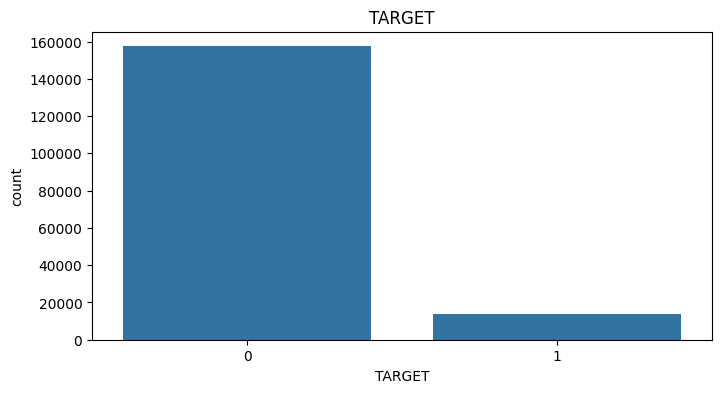

In [16]:
f,ax = plt.subplots(1,1,figsize = (8,4))
sns.countplot(x = "TARGET",data = df_)
ax.set_title("TARGET")
plt.show()

명목형 데이터 특성 개수 : 11


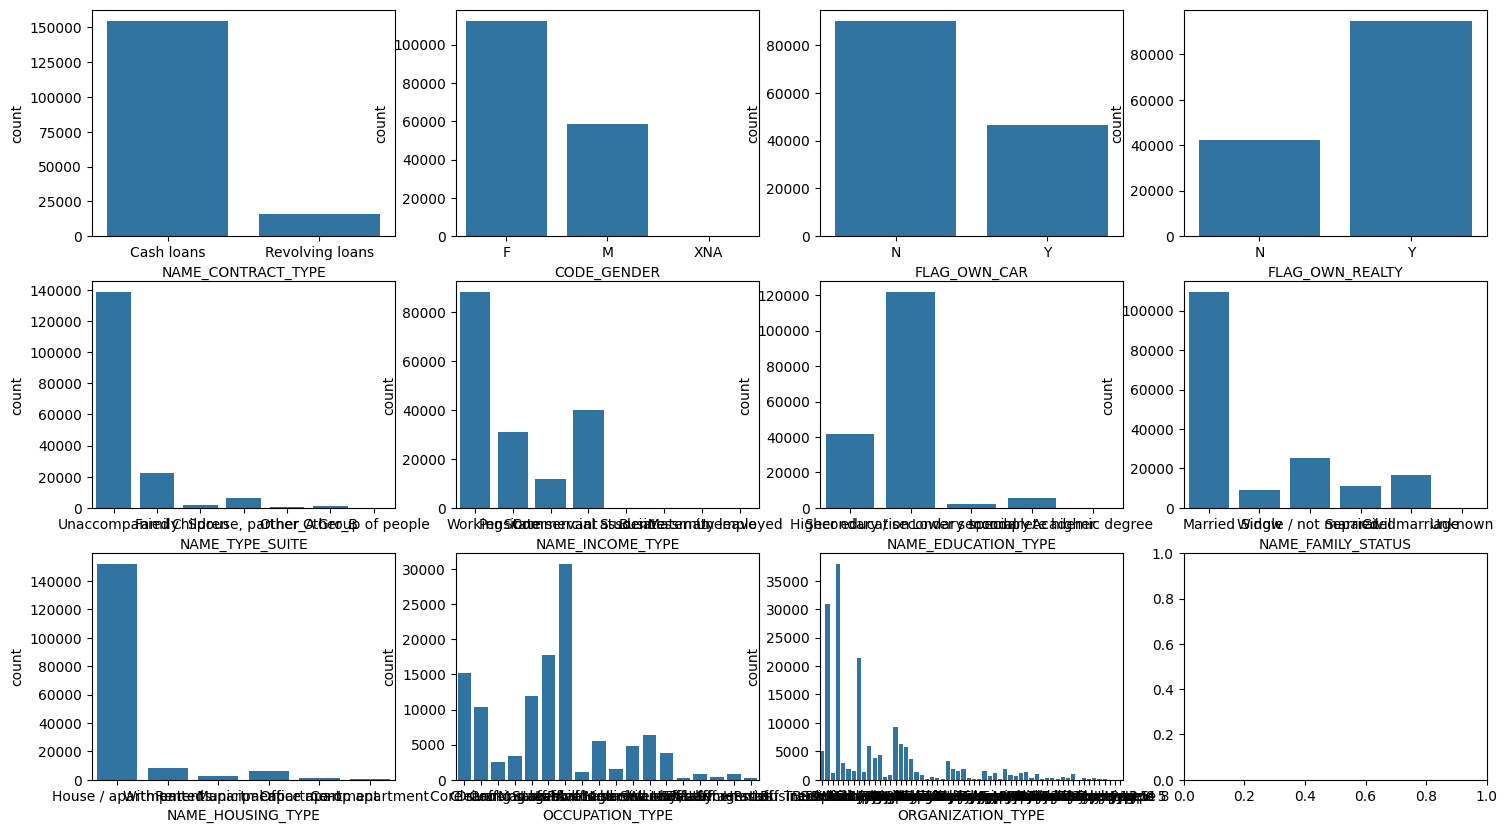

In [69]:
strarray = df_.select_dtypes("object").columns
print("명목형 데이터 특성 개수 : {}".format(len(strarray)))

fig , ax = plt.subplots(3 , 4 , figsize = (18 , 10))

for i in range(11):
    row = i // 4
    col = i % 4

    sns.countplot(data = df_ , x = df_[strarray[i]] , ax = ax[row][col])
    ax[row][col].set_title("".format(str(strarray[i])))
plt.show()

명목형 데이터 특성 개수 : 11


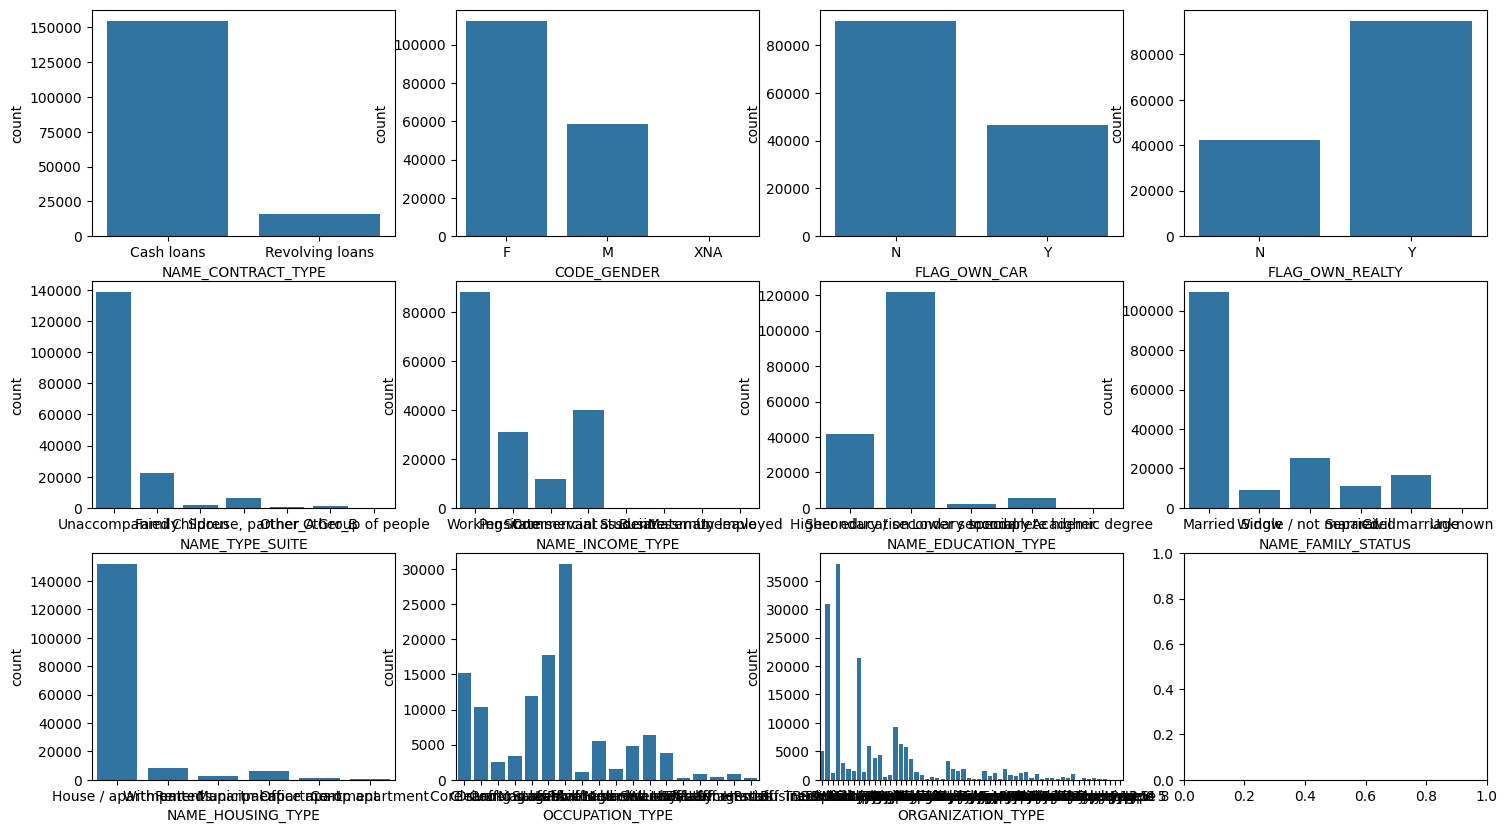

In [17]:
strarray = df_.select_dtypes("object").columns
print("명목형 데이터 특성 개수 : {}".format(len(strarray)))

fig , ax = plt.subplots(3 , 4 , figsize = (18 , 10))

for i in range(11):
    row = i // 4
    col = i % 4

    sns.countplot(data = df_ , x = df_[strarray[i]] , ax = ax[row][col])
    ax[row][col].set_title("".format(str(strarray[i])))
plt.show()

In [92]:
dfnum = df.copy()
strarray = df_.select_dtypes("object").columns
dfnum.drop(strarray,axis = 1,inplace=True)
dfnum.drop("SK_ID_CURR",axis = 1,inplace=True)
dfnum.head()

TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0       0             0          112500.0    755190.0      36328.5   
1       0             0          225000.0    585000.0      16893.0   
2       0             0           54000.0    334152.0      18256.5   
3       0             0           67500.0    152820.0       8901.0   
4       1             0          157500.0    271066.5      21546.0   

   AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0         675000.0                    0.010032       -9233           -878   
1         585000.0                    0.008019      -20148         365243   
2         270000.0                    0.004960      -18496           -523   
3         135000.0                    0.005002      -24177         365243   
4         234000.0                    0.006296      -10685           -697   

   DAYS_REGISTRATION  ...  EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  \
0             -333.0  ...           NaN                       0.0   
1            -4469.0  ...      0.553165                       0.0   
2            -3640.0  ...           NaN                       4.0   
3            -4950.0  ...      0.767523                       0.0   
4            -5101.0  ...      0.669057                       0.0   

   DEF_30_CNT_SOCIAL_CIRCLE  OBS_60_CNT_SOCIAL_CIRCLE  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       4.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   DEF_60_CNT_SOCIAL_CIRCLE  DAYS_LAST_PHONE_CHANGE  \
0                       0.0                  -292.0   
1                       0.0                  -617.0   
2                       0.0                  -542.0   
3                       0.0                     0.0   
4                       0.0                 -1243.0   

   AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_MON  \
0                         NaN                        NaN   
1                         0.0                        0.0   
2                         NaN                        NaN   
3                         0.0                        0.0   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        NaN                         NaN  
1                        0.0                         1.0  
2                        NaN                         NaN  
3                        0.0                         0.0  
4                        0.0                         4.0  

[5 rows x 39 columns]

<Axes: >

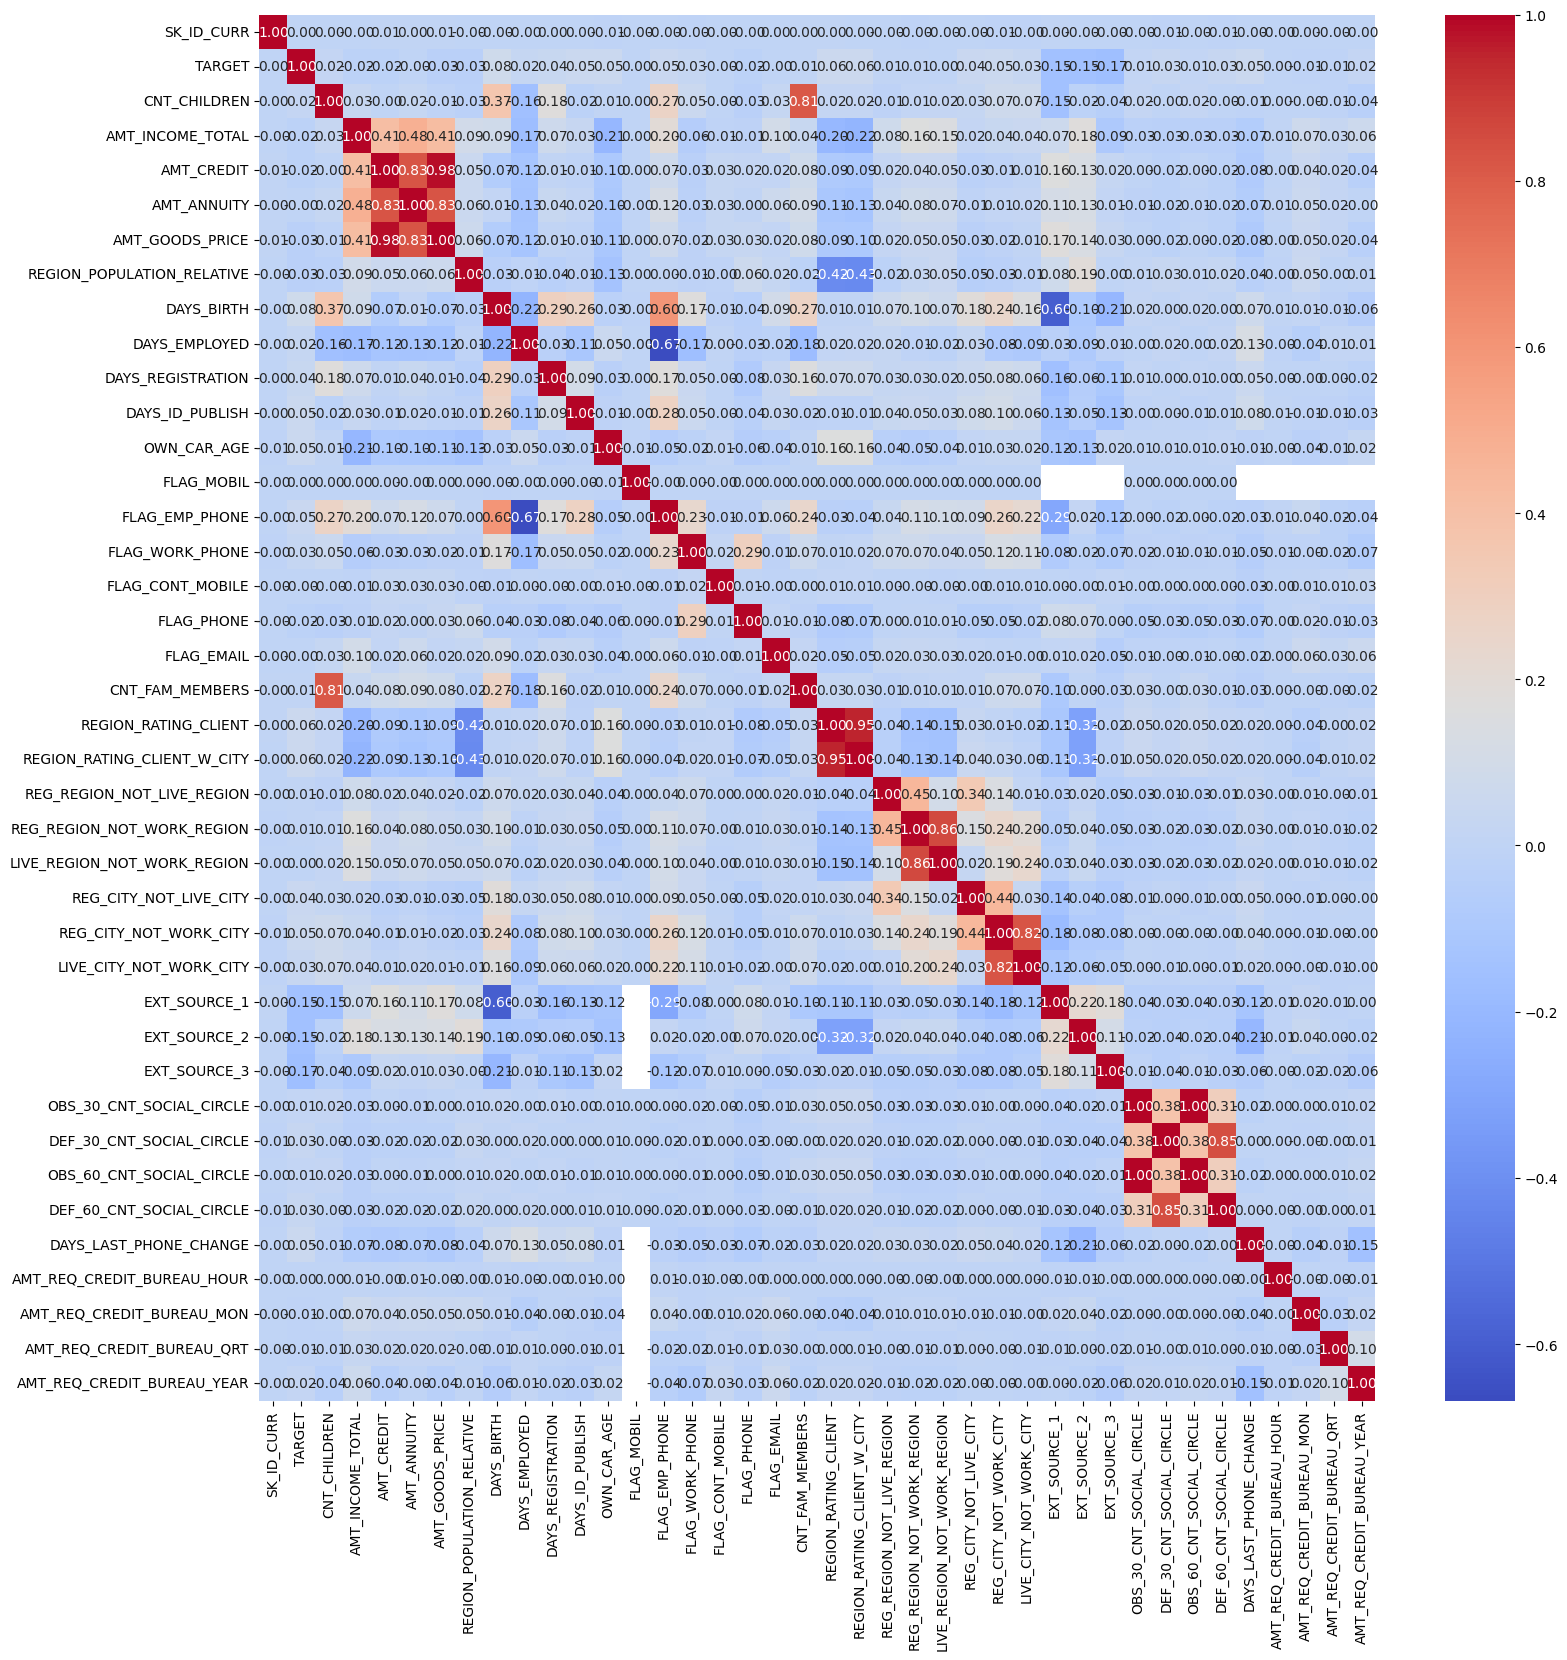

In [26]:
plt.figure(figsize=(18, 18))

sns.heatmap(data = df_.select_dtypes(['int' , 'float']).corr('spearman') ,
            annot = True ,
            fmt = '.2f' ,
            
            cmap = 'coolwarm')

In [4]:
strarray = df_.select_dtypes("object").columns
len(strarray)

11

In [5]:

df_["credit_goods_price_ratio"] = df_["AMT_CREDIT"] / df_["AMT_GOODS_PRICE"]
df_["credit_downpayment"] = df_["AMT_GOODS_PRICE"] - df_["AMT_CREDIT"]
df_["AGE_INT"] = (df_["DAYS_BIRTH"] / -365).astype(int)

In [6]:

test["credit_goods_price_ratio"] = test["AMT_CREDIT"] / test["AMT_GOODS_PRICE"]
test["credit_downpayment"] = test["AMT_GOODS_PRICE"] - test["AMT_CREDIT"]
test["AGE_INT"] = (test["DAYS_BIRTH"] / -365).astype(int)

In [7]:
# 파생변수 생성
df_["AMT_Percentage"] = df_["AMT_ANNUITY"] +df_["AMT_GOODS_PRICE"]/ df_["AMT_CREDIT"]
test["AMT_Percentage"] = test["AMT_ANNUITY"] +test["AMT_GOODS_PRICE"]/ test["AMT_CREDIT"]



In [8]:
df_['INCOME_TOTAL_CREDIT'] = df_['AMT_INCOME_TOTAL'] / df_['AMT_CREDIT']
    
df_['DAYS_BIRTH_365_OWN_CAR_AGE'] = (df_['DAYS_BIRTH'] / 365) - df_['OWN_CAR_AGE']

df_['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

In [9]:

test['INCOME_TOTAL_CREDIT'] = test['AMT_INCOME_TOTAL'] / test['AMT_CREDIT']
    
test['DAYS_BIRTH_365_OWN_CAR_AGE'] = (test['DAYS_BIRTH'] / 365) - test['OWN_CAR_AGE']

test['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

In [136]:
null_counts = df_.isnull().sum()

null_counts = null_counts[null_counts > 0]
print(null_counts)

FLAG_OWN_CAR                   34241
FLAG_OWN_REALTY                34241
AMT_ANNUITY                        6
AMT_GOODS_PRICE                  163
NAME_TYPE_SUITE                  747
DAYS_EMPLOYED                  30898
OWN_CAR_AGE                   112992
OCCUPATION_TYPE                53745
CNT_FAM_MEMBERS                    2
EXT_SOURCE_1                  118928
EXT_SOURCE_2                     369
EXT_SOURCE_3                   54586
OBS_30_CNT_SOCIAL_CIRCLE         560
DEF_30_CNT_SOCIAL_CIRCLE         560
OBS_60_CNT_SOCIAL_CIRCLE         560
DEF_60_CNT_SOCIAL_CIRCLE         560
DAYS_LAST_PHONE_CHANGE             1
AMT_REQ_CREDIT_BUREAU_HOUR     23116
AMT_REQ_CREDIT_BUREAU_MON      23116
AMT_REQ_CREDIT_BUREAU_QRT      23116
AMT_REQ_CREDIT_BUREAU_YEAR     23116
credit_goods_price_ratio         163
credit_downpayment               163
AMT_Percentage                   169
DAYS_BIRTH_365_OWN_CAR_AGE    112992
dtype: int64


In [10]:
test['DAYS_BIRTH'] = test['DAYS_BIRTH']//-360
# # 年齢を5歳ごとにラベリング（20から71までの範囲）
bins = range(20, 76, 5)  # 20から75まで5刻みのビンを作成
labels = list(range(1, len(bins)))  # 各ビンに対する数値ラベルを作成
test['age_group'] = pd.cut(test['DAYS_BIRTH'], bins=bins, labels=labels, right=False)

test['EXT_23_mean'] = (test['EXT_SOURCE_2'] + test['EXT_SOURCE_3']) / 2
test['EXT_12_mean'] = (test['EXT_SOURCE_1'] + test['EXT_SOURCE_2']) / 2
test['EXT_13_mean'] = (test['EXT_SOURCE_1'] + test['EXT_SOURCE_3']) / 2
test['EXT_123_mean'] = (test['EXT_SOURCE_1'] + test['EXT_SOURCE_2'] + test['EXT_SOURCE_3']) / 3

# 勤続日数/年齢日数
test['DAYS_EMPLOYED_PERC'] = test['DAYS_EMPLOYED'] / test['DAYS_BIRTH']
# # 総収入/家族人数
test['INCOME_PER_PERSON'] = test['AMT_INCOME_TOTAL'] / test['CNT_FAM_MEMBERS']
# # 月々の返済額/総収入
test['ANNUITY_INCOME_PERC'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']
# # 月々の返済額/借入額
test['PAYMENT_RATE'] = test['AMT_ANNUITY'] / test['AMT_CREDIT']

In [11]:
# 特徴量作成
df_['DAYS_BIRTH'] = df_['DAYS_BIRTH']//-360
# # 年齢を5歳ごとにラベリング（20から71までの範囲）
bins = range(20, 76, 5)  # 20から75まで5刻みのビンを作成
labels = list(range(1, len(bins)))  # 各ビンに対する数値ラベルを作成
df_['age_group'] = pd.cut(df_['DAYS_BIRTH'], bins=bins, labels=labels, right=False)

df_['EXT_23_mean'] = (df_['EXT_SOURCE_2'] + df_['EXT_SOURCE_3']) / 2
df_['EXT_12_mean'] = (df_['EXT_SOURCE_1'] + df_['EXT_SOURCE_2']) / 2
df_['EXT_13_mean'] = (df_['EXT_SOURCE_1'] + df_['EXT_SOURCE_3']) / 2
df_['EXT_123_mean'] = (df_['EXT_SOURCE_1'] + df_['EXT_SOURCE_2'] + df_['EXT_SOURCE_3']) / 3

# 勤続日数/年齢日数
df_['DAYS_EMPLOYED_PERC'] = df_['DAYS_EMPLOYED'] / df_['DAYS_BIRTH']
# # 総収入/借入額
# # 総収入/家族人数
df_['INCOME_PER_PERSON'] = df_['AMT_INCOME_TOTAL'] / df_['CNT_FAM_MEMBERS']
# # 月々の返済額/総収入
df_['ANNUITY_INCOME_PERC'] = df_['AMT_ANNUITY'] / df_['AMT_INCOME_TOTAL']
# # 月々の返済額/借入額
df_['PAYMENT_RATE'] = df_['AMT_ANNUITY'] / df_['AMT_CREDIT']




# +A

In [12]:
df_['AGE_YEARS'] = df_['DAYS_BIRTH'] / -365

df_['PAYMENT_Difference'] =  df_['AMT_CREDIT']  - df_['AMT_ANNUITY'] 
df_['CREDIT_INCOME_PERC'] =  df_['AMT_CREDIT']/df_['AMT_INCOME_TOTAL'] 
df_['YEARS_EMPLOYED'] = df_['DAYS_EMPLOYED'] / -365
education_income_mean = df_.groupby('NAME_EDUCATION_TYPE')['AMT_INCOME_TOTAL'].mean()
df_['EDU_INCOME_ABOVE_AVG'] = df_.apply(
    lambda x: 1 if x['AMT_INCOME_TOTAL'] > education_income_mean[x['NAME_EDUCATION_TYPE']] else 0,
    axis=1
)

df_['AVG_REGION_RATING'] = (df_['REGION_RATING_CLIENT'] + df_['REGION_RATING_CLIENT_W_CITY']) / 2
df_['SOCIAL_CIRCLE_RATIO'] = df_['OBS_30_CNT_SOCIAL_CIRCLE'] / df_['DEF_30_CNT_SOCIAL_CIRCLE']
income_std_by_type = df_.groupby('NAME_INCOME_TYPE')['AMT_INCOME_TOTAL'].std()
df_['INCOME_STD'] = df_['NAME_INCOME_TYPE'].map(income_std_by_type)
df_['REALTY_AGE_RATIO'] = df_['OWN_CAR_AGE'] / df_['AGE_YEARS']


In [13]:
test['AGE_YEARS'] = test['DAYS_BIRTH'] / -365
test['PAYMENT_Difference'] =  test['AMT_CREDIT'] - test['AMT_ANNUITY'] 
test['CREDIT_INCOME_PERC'] =  test['AMT_CREDIT']/test['AMT_INCOME_TOTAL'] 
test['YEARS_EMPLOYED'] = test['DAYS_EMPLOYED'] / -365
education_income_mean = test.groupby('NAME_EDUCATION_TYPE')['AMT_INCOME_TOTAL'].mean()
test['EDU_INCOME_ABOVE_AVG'] = test.apply(
    lambda x: 1 if x['AMT_INCOME_TOTAL'] > education_income_mean[x['NAME_EDUCATION_TYPE']] else 0,
    axis=1
)

test['AVG_REGION_RATING'] = (test['REGION_RATING_CLIENT'] + test['REGION_RATING_CLIENT_W_CITY']) / 2
test['SOCIAL_CIRCLE_RATIO'] = test['OBS_30_CNT_SOCIAL_CIRCLE'] / test['DEF_30_CNT_SOCIAL_CIRCLE']
income_std_by_type = test.groupby('NAME_INCOME_TYPE')['AMT_INCOME_TOTAL'].std()
test['INCOME_STD'] = test['NAME_INCOME_TYPE'].map(income_std_by_type)
test['REALTY_AGE_RATIO'] = test['OWN_CAR_AGE'] / test['AGE_YEARS']


df_["NAME_INCOME_TYPE"] = df_["NAME_INCOME_TYPE"].replace(['Pensioner','Commercial associate','Student',
                                                            'Businessman','Maternity leave','Unemployed'],np.nan)
df_["NAME_EDUCATION_TYPE"] = df_["NAME_EDUCATION_TYPE"].replace(['Lower secondary','Incomplete higher'] ,np.nan)
df_["NAME_HOUSING_TYPE"] = df_["NAME_HOUSING_TYPE"].replace( ['Co-op apartment','Municipal apartment'],np.nan)

test["NAME_INCOME_TYPE"] = test["NAME_INCOME_TYPE"].replace(['Pensioner','Commercial associate','Student',
                                                            'Businessman','Maternity leave','Unemployed'],np.nan)
test["NAME_EDUCATION_TYPE"] = test["NAME_EDUCATION_TYPE"].replace(['Lower secondary','Incomplete higher'] ,np.nan)
test["NAME_HOUSING_TYPE"] = test["NAME_HOUSING_TYPE"].replace( ['Co-op apartment','Municipal apartment'],np.nan)

In [14]:
dropcolumns = ['AGE_YEARS',"age_group",'FLAG_MOBIL','REG_REGION_NOT_LIVE_REGION','FLAG_CONT_MOBILE','FLAG_EMAIL','FLAG_EMP_PHONE','LIVE_CITY_NOT_WORK_CITY','LIVE_REGION_NOT_WORK_REGION','REG_REGION_NOT_WORK_REGION','REG_CITY_NOT_WORK_CITY','AMT_REQ_CREDIT_BUREAU_HOUR','FLAG_OWN_REALTY','NAME_TYPE_SUITE','CNT_CHILDREN','FLAG_PHONE']
df_.drop(dropcolumns,axis = 1,inplace=True)
test.drop(dropcolumns,axis = 1,inplace=True)

# model

In [82]:
Ndf = df_.copy()
Ntest = test.copy()

In [83]:
Ndf = Ndf.replace([np.inf,-np.inf],np.nan)
Ntest =  Ntest.replace([np.inf,-np.inf],np.nan)

In [16]:
Ndf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171202 entries, 0 to 171201
Data columns (total 32 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   171202 non-null  int64  
 1   TARGET                       171202 non-null  int64  
 2   NAME_CONTRACT_TYPE           171202 non-null  object 
 3   CODE_GENDER                  171202 non-null  object 
 4   FLAG_OWN_CAR                 136961 non-null  object 
 5   AMT_INCOME_TOTAL             171202 non-null  float64
 6   NAME_INCOME_TYPE             171202 non-null  object 
 7   NAME_EDUCATION_TYPE          171202 non-null  object 
 8   NAME_FAMILY_STATUS           171202 non-null  object 
 9   NAME_HOUSING_TYPE            171202 non-null  object 
 10  REGION_POPULATION_RELATIVE   171202 non-null  float64
 11  DAYS_BIRTH                   171202 non-null  int64  
 12  DAYS_EMPLOYED                140304 non-null  float64
 13 

In [61]:
Ntest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61500 entries, 0 to 61499
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SK_ID_CURR                   61500 non-null  int64  
 1   NAME_CONTRACT_TYPE           61500 non-null  object 
 2   CODE_GENDER                  61500 non-null  object 
 3   AMT_INCOME_TOTAL             61500 non-null  float64
 4   NAME_INCOME_TYPE             61500 non-null  object 
 5   NAME_EDUCATION_TYPE          61500 non-null  object 
 6   NAME_FAMILY_STATUS           61500 non-null  object 
 7   NAME_HOUSING_TYPE            61500 non-null  object 
 8   REGION_POPULATION_RELATIVE   61500 non-null  float64
 9   DAYS_BIRTH                   61500 non-null  int64  
 10  DAYS_EMPLOYED                61500 non-null  int64  
 11  DAYS_REGISTRATION            61500 non-null  float64
 12  DAYS_ID_PUBLISH              61500 non-null  int64  
 13  FLAG_MOBIL      

In [10]:
df_.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60

<Axes: >

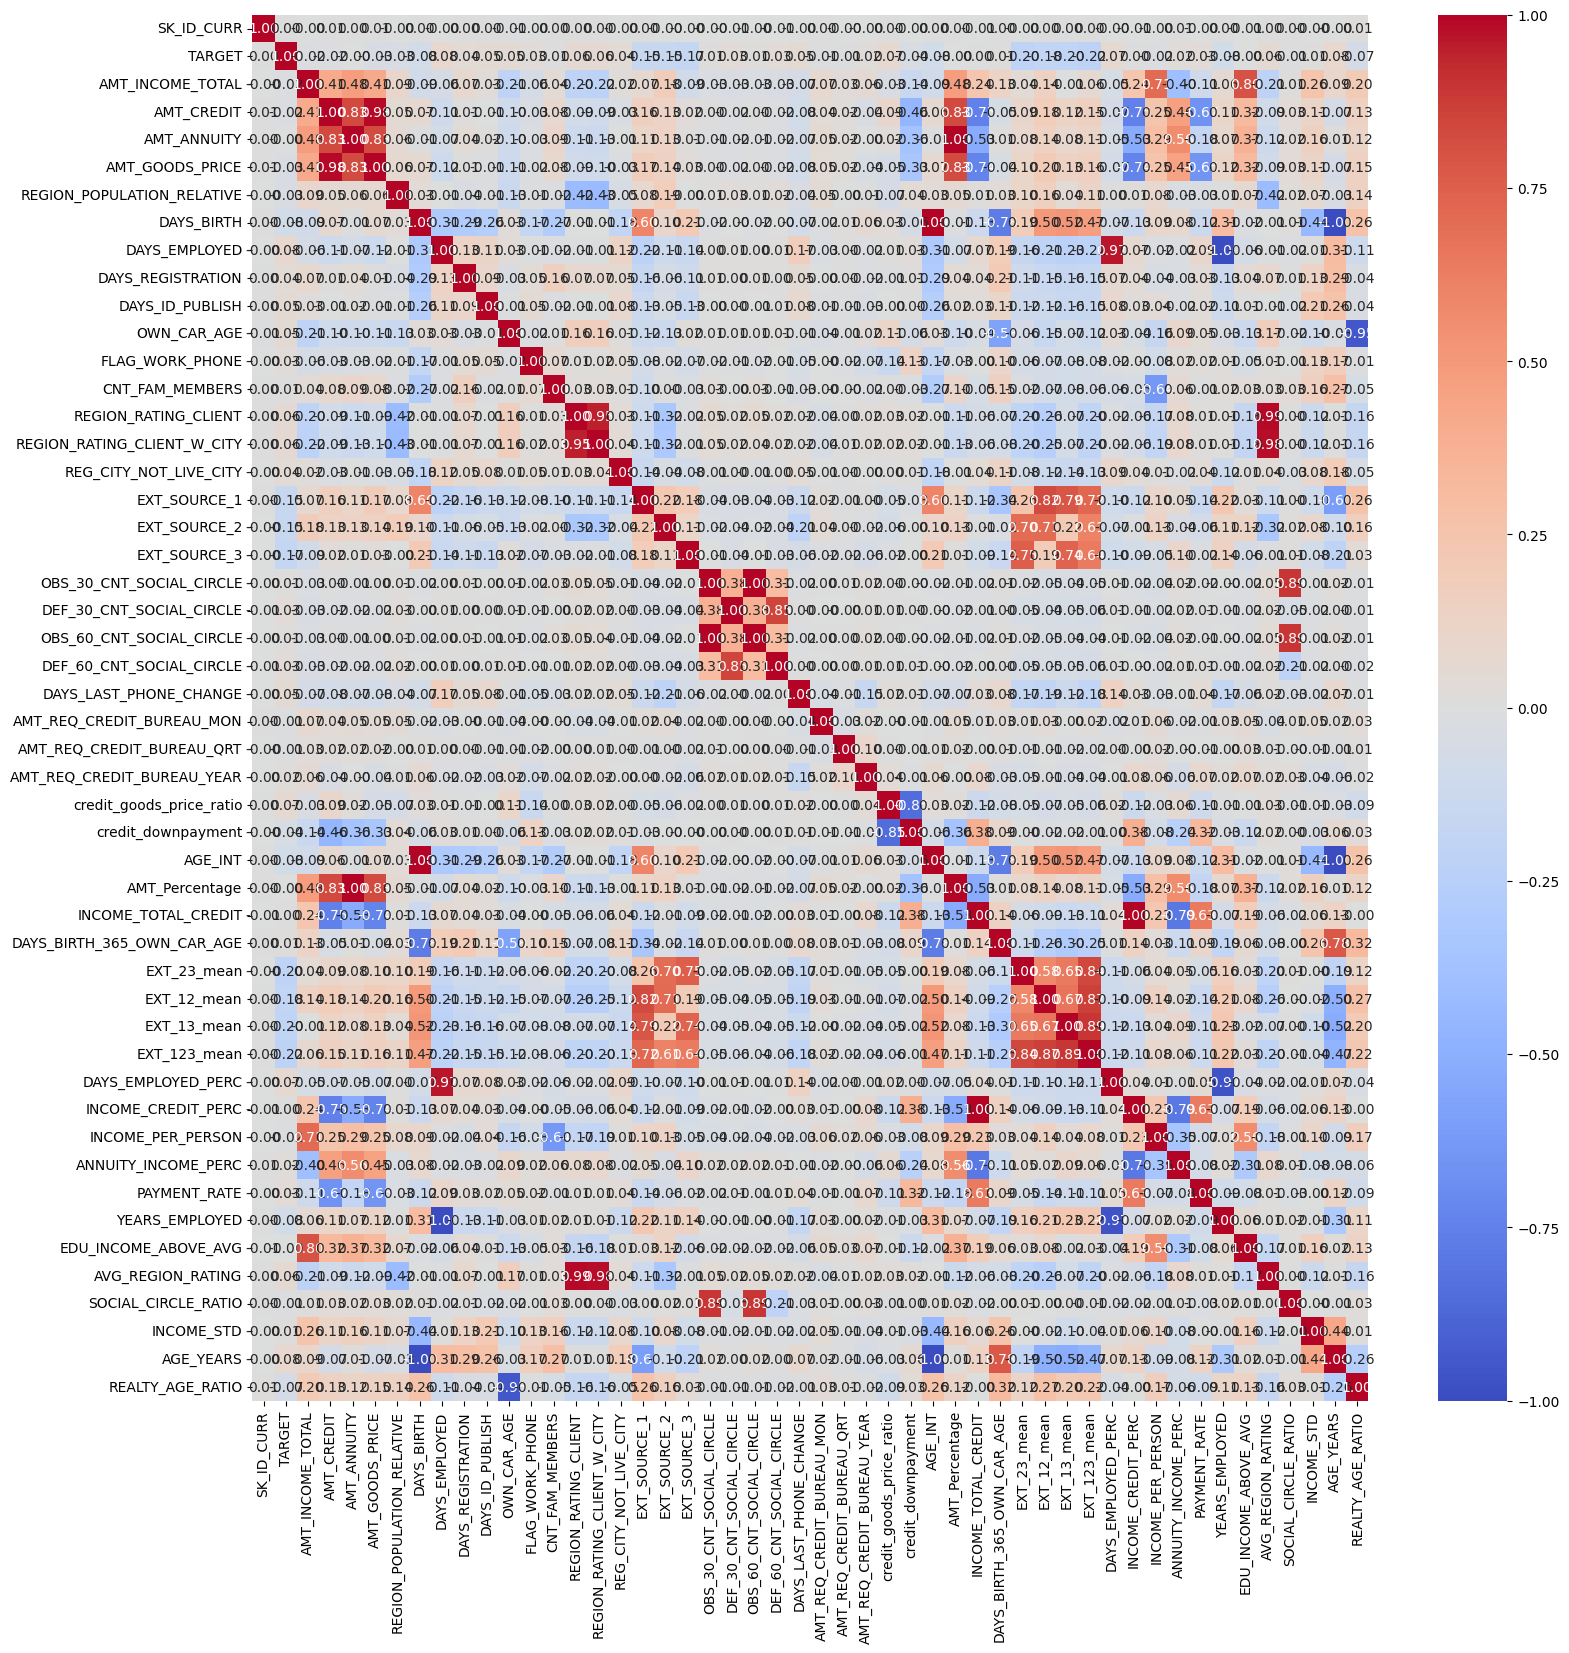

In [16]:

plt.figure(figsize=(18, 18))

sns.heatmap(data = Ndf.select_dtypes(['int' , 'float']).corr('spearman'),
            annot = True ,
            fmt = '.2f' ,
            
            cmap = 'coolwarm')

In [10]:
Ntest.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'OWN_CAR_AGE', 'FLAG_WORK_PHONE', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'AMT_Percentage'],
      dtype='object')

In [51]:
Ntest.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'OWN_CAR_AGE', 'FLAG_WORK_PHONE', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'AMT_Percentage'],
      dtype='object')

In [19]:
Nstrarray = Ndf.select_dtypes("object").columns
len(Nstrarray)

9

명목형 데이터 특성 개수 : 9


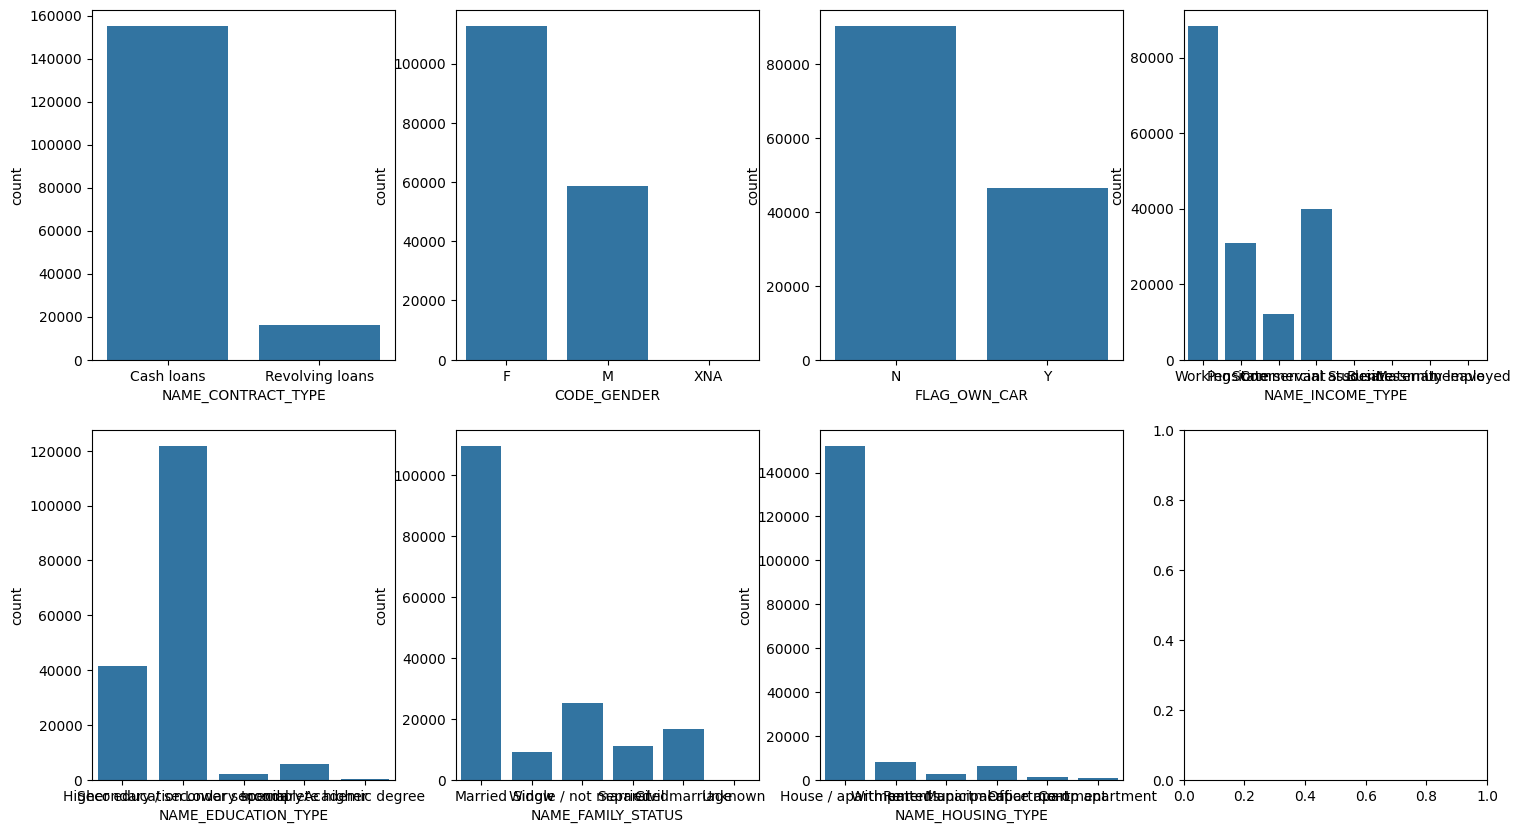

In [7]:
Nstrarray = Ndf.select_dtypes("object").columns
print("명목형 데이터 특성 개수 : {}".format(len(Nstrarray)))

fig , ax = plt.subplots(2 , 4 , figsize = (18 , 10))

for i in range(7):
    row = i // 4
    col = i % 4

    sns.countplot(data = Ndf, x = Ndf[Nstrarray[i]] , ax = ax[row][col])
    ax[row][col].set_title("".format(str(Nstrarray[i])))
plt.show()

In [50]:
list(Ntest.select_dtypes("int").columns)
list(Ntest.select_dtypes("float").columns)

['AMT_INCOME_TOTAL',
 'REGION_POPULATION_RELATIVE',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'OWN_CAR_AGE',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'AMT_Percentage']

명목형 데이터 특성 개수 : 9


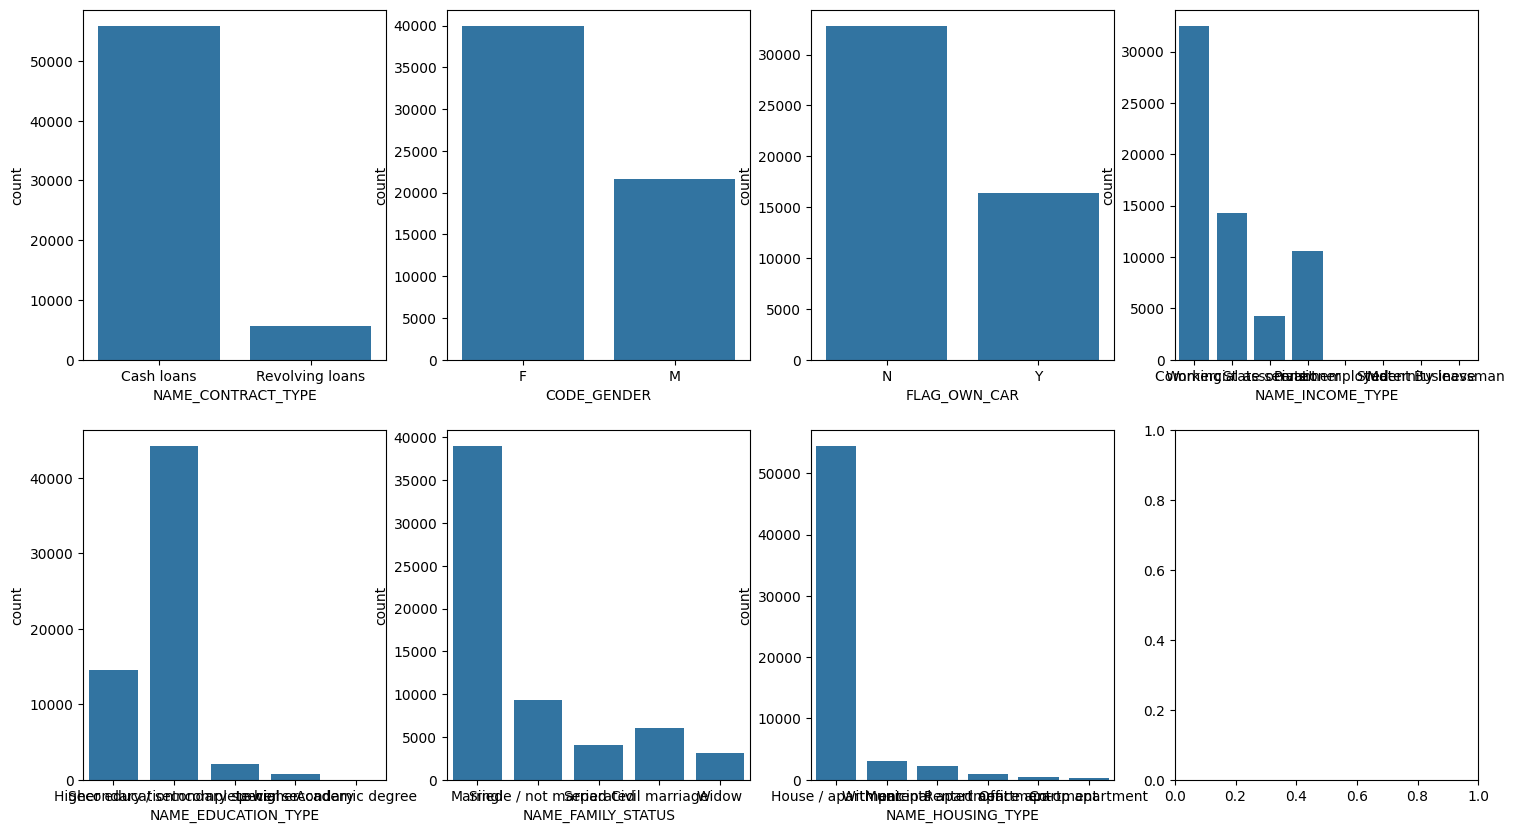

In [35]:
Nstrarray = Ntest.select_dtypes("object").columns
print("명목형 데이터 특성 개수 : {}".format(len(Nstrarray)))

fig , ax = plt.subplots(2 , 4 , figsize = (18 , 10))

for i in range(7):
    row = i // 4
    col = i % 4

    sns.countplot(data = Ntest, x = Ntest[Nstrarray[i]] , ax = ax[row][col])
    ax[row][col].set_title("".format(str(Nstrarray[i])))
plt.show()

In [13]:
I =list(Ntest.select_dtypes("int").columns)
F = list(Ntest.select_dtypes("float").columns)
numcolumns = I+F


In [14]:

removecolumns = ["SK_ID_CURR","REGION_POPULATION_RELATIVE",'FLAG_WORK_PHONE',
                 'REGION_RATING_CLIENT_W_CITY','REG_CITY_NOT_LIVE_CITY','CNT_FAM_MEMBERS']
for i in removecolumns:
    numcolumns.remove(i)
print(len(numcolumns))

36


In [62]:
for i in removecolumns:
    print(Ndf[i].unique())

[     0      1      2 ... 171199 171200 171201]
[0.010032 0.008019 0.00496  0.005002 0.006296 0.018209 0.011657 0.006671
 0.010643 0.020713 0.022625 0.018029 0.072508 0.01452  0.04622  0.003818
 0.003813 0.031329 0.025164 0.002134 0.035792 0.00712  0.01885  0.002042
 0.02461  0.007114 0.026392 0.004849 0.008866 0.030755 0.008575 0.003069
 0.018634 0.010147 0.020246 0.00702  0.019101 0.016612 0.010966 0.019689
 0.018801 0.028663 0.005144 0.006305 0.007305 0.010006 0.006008 0.015221
 0.009334 0.009175 0.0228   0.009549 0.002506 0.011703 0.00733  0.008625
 0.008474 0.00963  0.006852 0.008068 0.005313 0.032561 0.003122 0.006629
 0.006233 0.010556 0.006207 0.009657 0.00823  0.014464 0.0105   0.005084
 0.007274 0.010276 0.001417 0.001276 0.003541 0.001333 0.000938 0.000533
 0.00029 ]
[1 0]
[2 3 1]
[0 1]
[ 2.  1.  3.  4.  5.  6.  7.  8. 11. nan 12.  9. 14. 10. 15. 16.]


int or float columns : 36


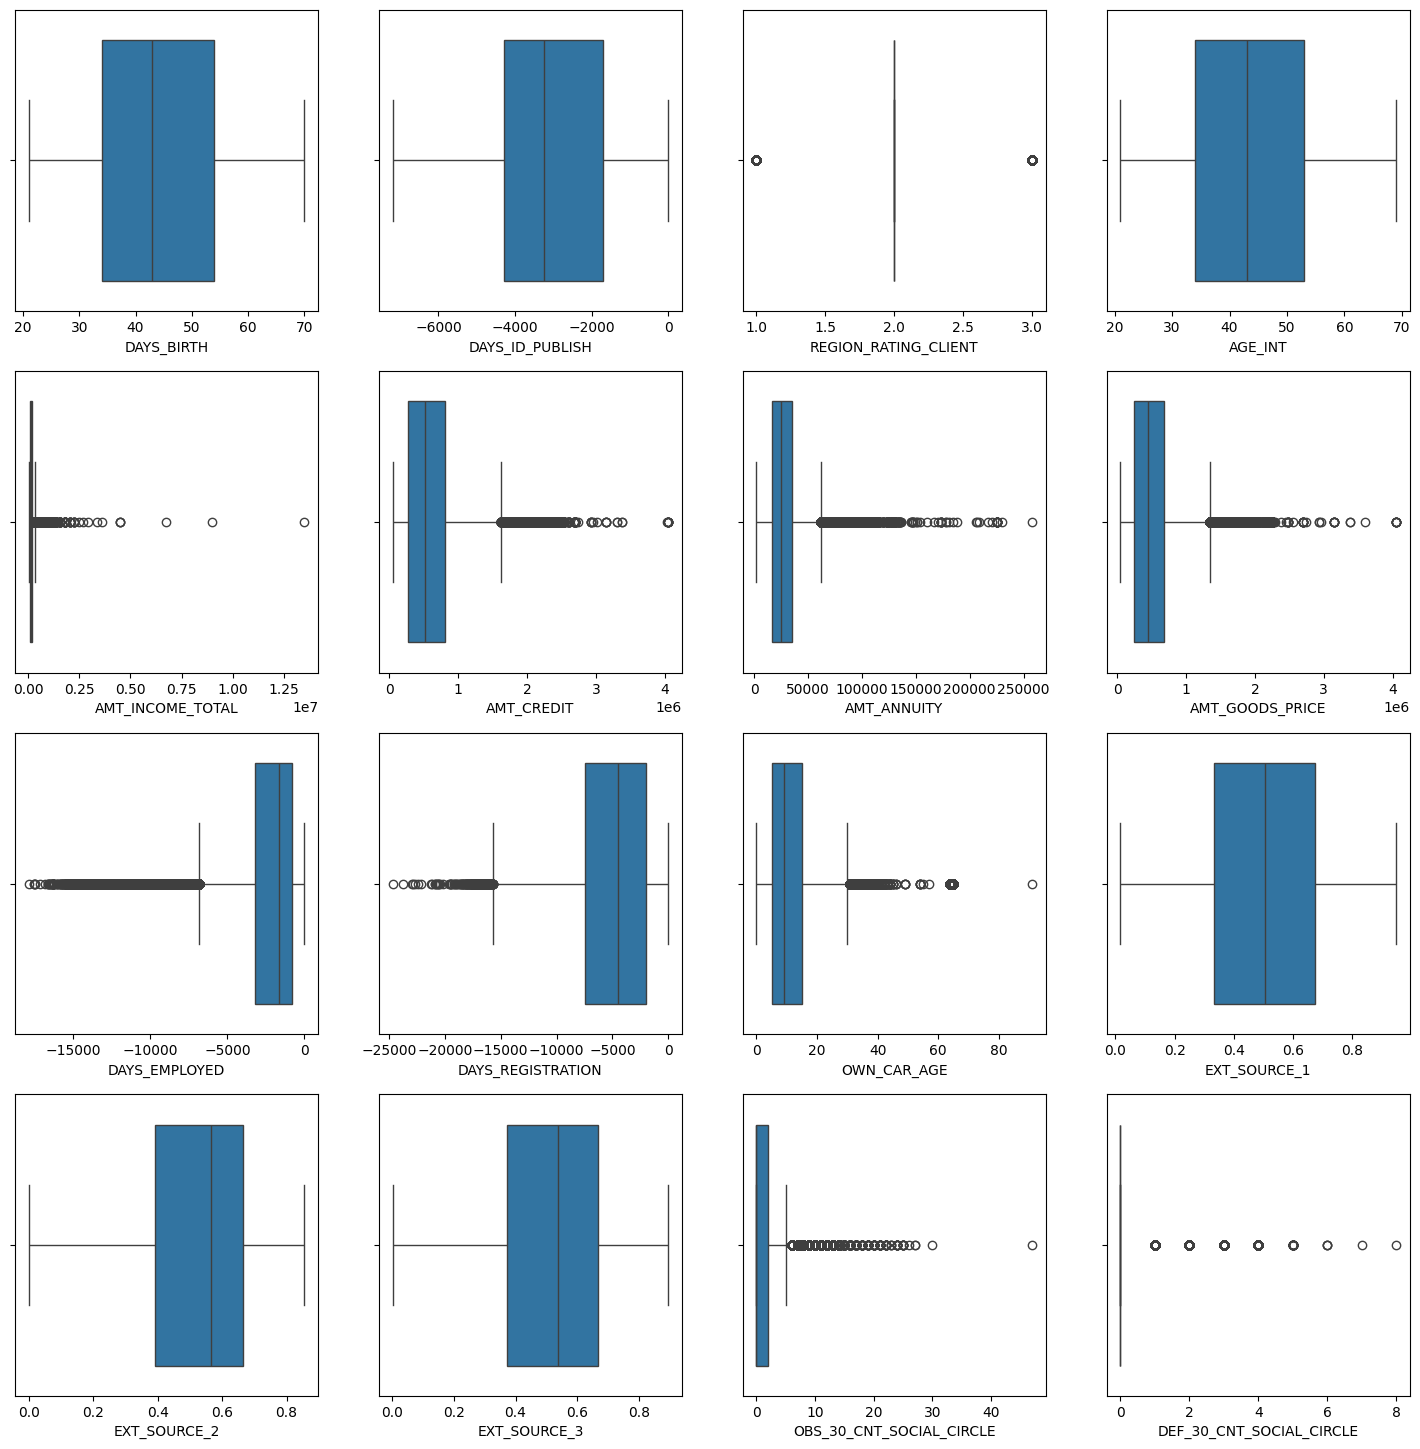

In [15]:
print("int or float columns : {}".format(len(numcolumns)))

fig , ax = plt.subplots(4 , 4 , figsize = (18 , 18))

for i in range(16):
    row = i // 4
    col = i % 4

    sns.boxplot(data = Ndf, x = Ndf[numcolumns[i]] , ax = ax[row][col])
    ax[row][col].set_title("".format(str(numcolumns[i])))
plt.show()

int or float columns : 16


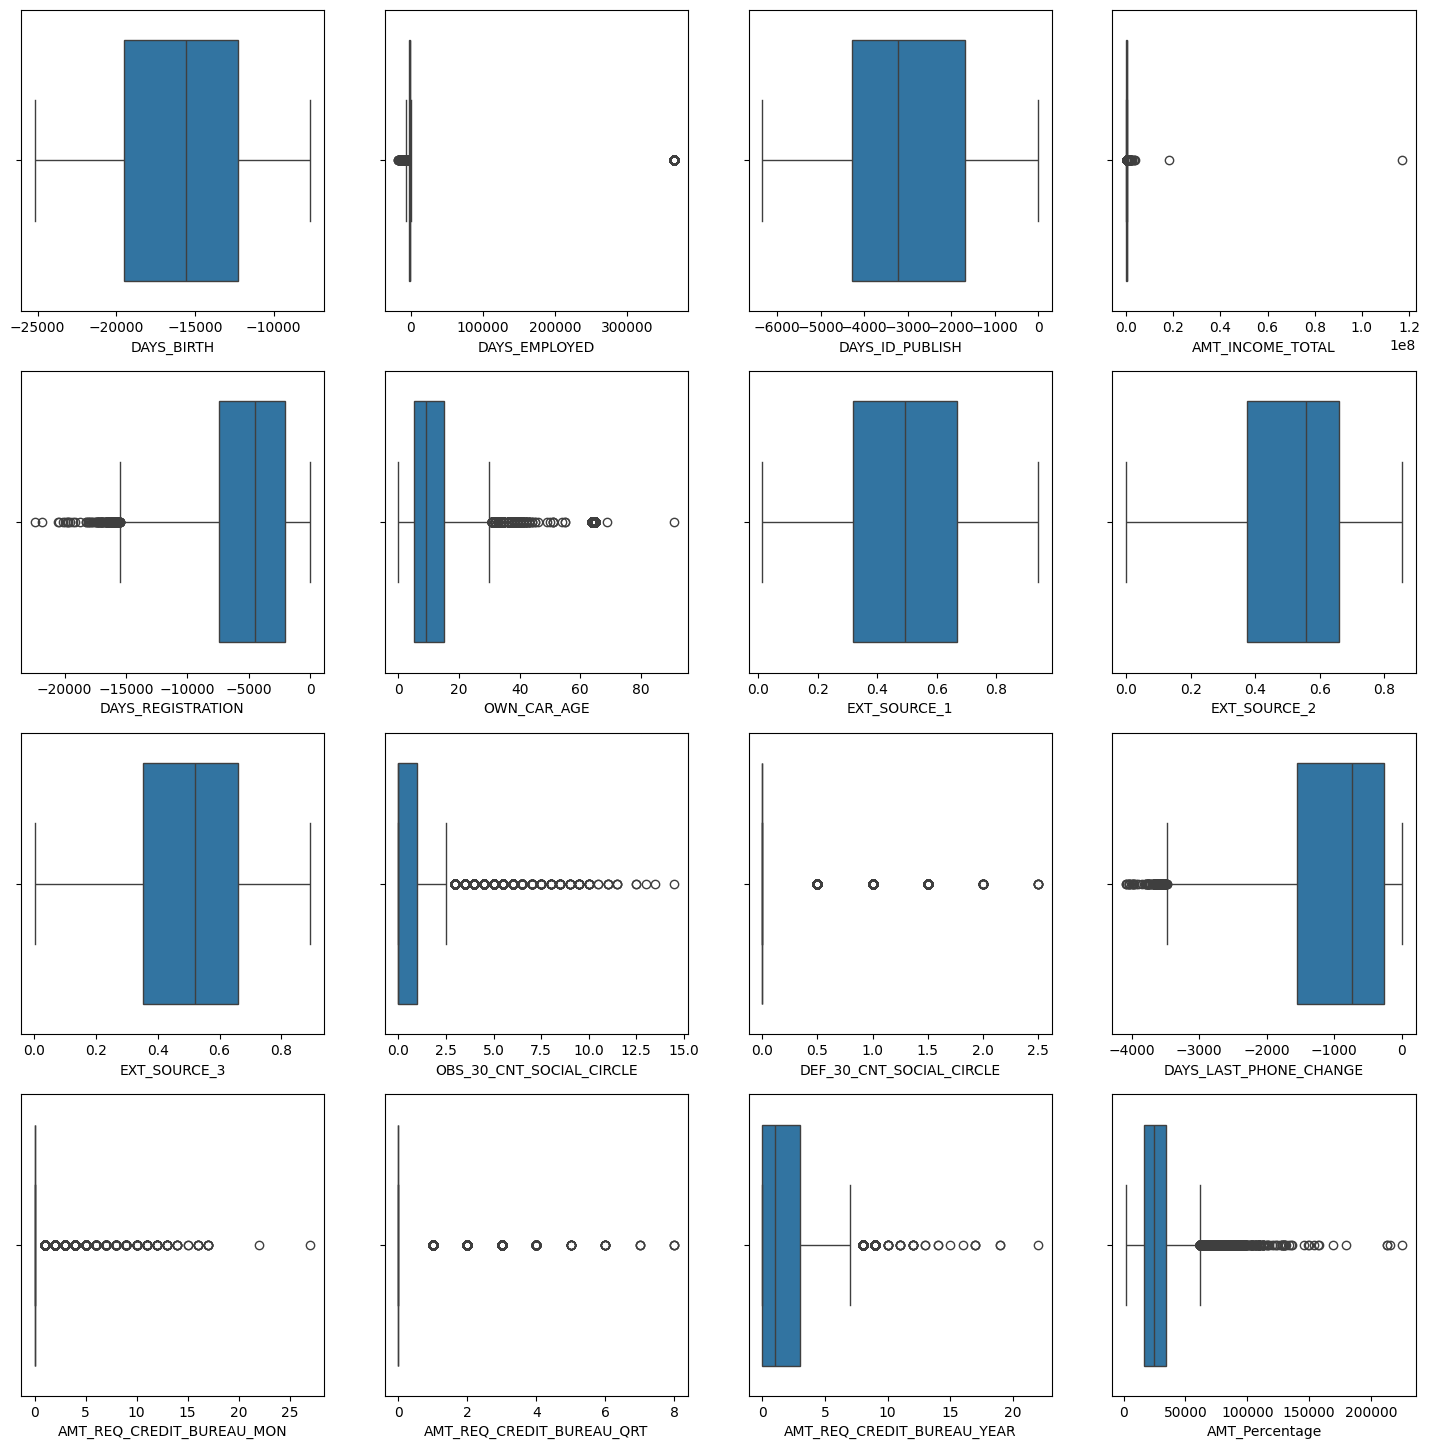

In [31]:
print("int or float columns : {}".format(len(numcolumns)))

fig , ax = plt.subplots(4 , 4 , figsize = (18 , 18))

for i in range(16):
    row = i // 4
    col = i % 4

    sns.boxplot(data = Ntest, x = Ntest[numcolumns[i]] , ax = ax[row][col])
    ax[row][col].set_title("".format(str(numcolumns[i])))
plt.show()

In [16]:
numcolumns

['DAYS_BIRTH',
 'DAYS_ID_PUBLISH',
 'REGION_RATING_CLIENT',
 'AGE_INT',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'OWN_CAR_AGE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'credit_goods_price_ratio',
 'credit_downpayment',
 'AMT_Percentage',
 'INCOME_TOTAL_CREDIT',
 'DAYS_BIRTH_365_OWN_CAR_AGE',
 'EXT_23_mean',
 'EXT_12_mean',
 'EXT_13_mean',
 'EXT_123_mean',
 'DAYS_EMPLOYED_PERC',
 'INCOME_CREDIT_PERC',
 'INCOME_PER_PERSON',
 'ANNUITY_INCOME_PERC',
 'PAYMENT_RATE']

In [17]:
# tukey

def tukey(data , c):
    q1 = np.percentile(data[c] , 25)
    q3 = np.percentile(data[c] , 75)

    IQR = q3 - q1

    upper_fence = q3 + 1.5 * IQR
    lower_fence = q1 - 1.5 * IQR

    return data[(data[c] < lower_fence) | (data[c] > upper_fence)]

In [18]:
outlierarray =['DAYS_EMPLOYED',
 'AMT_INCOME_TOTAL',
 'DAYS_REGISTRATION',
 'OWN_CAR_AGE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'AMT_Percentage']
 

In [21]:
# 비율 확인

length = Ndf.shape[0]
t_length = Ntest.shape[0]
for i in outlierarray:
    print("{0} Outlier Percentage :{1}%".format(i,round((tukey(Ndf , i).shape[0]) / length * 100 , 10)))
    print("Test {0} Outlier Percentage :{1}%".format(i,round((tukey(Ntest ,i).shape[0]) / t_length * 100,10)))


DAYS_EMPLOYED Outlier Percentage :0.0%
Test DAYS_EMPLOYED Outlier Percentage :0.0%
AMT_INCOME_TOTAL Outlier Percentage :4.5466758566%
Test AMT_INCOME_TOTAL Outlier Percentage :4.3756097561%
DAYS_REGISTRATION Outlier Percentage :0.2032686534%
Test DAYS_REGISTRATION Outlier Percentage :0.2325203252%
OWN_CAR_AGE Outlier Percentage :0.0%
Test OWN_CAR_AGE Outlier Percentage :0.0%
OBS_30_CNT_SOCIAL_CIRCLE Outlier Percentage :0.0%
Test OBS_30_CNT_SOCIAL_CIRCLE Outlier Percentage :0.0%
DEF_30_CNT_SOCIAL_CIRCLE Outlier Percentage :0.0%
Test DEF_30_CNT_SOCIAL_CIRCLE Outlier Percentage :0.0%
OBS_30_CNT_SOCIAL_CIRCLE Outlier Percentage :0.0%
Test OBS_30_CNT_SOCIAL_CIRCLE Outlier Percentage :0.0%
DEF_30_CNT_SOCIAL_CIRCLE Outlier Percentage :0.0%
Test DEF_30_CNT_SOCIAL_CIRCLE Outlier Percentage :0.0%
DAYS_LAST_PHONE_CHANGE Outlier Percentage :0.0%
Test DAYS_LAST_PHONE_CHANGE Outlier Percentage :0.1756097561%
AMT_REQ_CREDIT_BUREAU_MON Outlier Percentage :0.0%
Test AMT_REQ_CREDIT_BUREAU_MON Outlier Pe

In [84]:
# outlier
Ntest.loc[Ntest["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = 60
Ntest['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
Ndf.loc[Ndf["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = 60
Ndf['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)



In [52]:
print(Ndf["NAME_EDUCATION_TYPE"].unique())
print(Ntest["NAME_EDUCATION_TYPE"].unique())

['Higher education' 'Secondary / secondary special' 'Lower secondary'
 'Incomplete higher' 'Academic degree']
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']


In [53]:
print(Ndf["NAME_INCOME_TYPE"].unique())
print(Ntest["NAME_INCOME_TYPE"].unique())

['Working' 'Pensioner' 'State servant' 'Commercial associate' 'Student'
 'Businessman' 'Maternity leave' 'Unemployed']
['Working' 'Commercial associate' 'State servant' 'Pensioner' 'Unemployed'
 'Student' 'Maternity leave' 'Businessman']


In [54]:

print(Ndf["NAME_HOUSING_TYPE"].unique())
print(Ntest["NAME_HOUSING_TYPE"].unique())

['House / apartment' 'With parents' 'Rented apartment'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
['House / apartment' 'With parents' 'Municipal apartment'
 'Rented apartment' 'Office apartment' 'Co-op apartment']


In [56]:

print(Ndf["NAME_HOUSING_TYPE"].unique())
print(Ntest["NAME_HOUSING_TYPE"].unique())

['House / apartment' 'With parents' 'Rented apartment'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
['House / apartment' 'With parents' 'Municipal apartment'
 'Rented apartment' 'Office apartment' 'Co-op apartment']


In [85]:
# CODE_GENDER
mode = Ndf["CODE_GENDER"].mode().iloc[0]
Ndf["CODE_GENDER"] = Ndf["CODE_GENDER"].replace('XNA', mode)

In [66]:
Ndf[Ndf["NAME_FAMILY_STATUS"] == "Unknown"]

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
47453       47453       0    Revolving loans           F            N   
74592       74592       0    Revolving loans           M            N   

       AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
47453          202500.0    585000.0      29250.0              NaN   
74592          450000.0    675000.0      33750.0              NaN   

      NAME_INCOME_TYPE  ... AMT_Percentage EXT_23_mean EXT_12_mean  \
47453              NaN  ...            NaN     0.65791         NaN   
74592              NaN  ...            NaN         NaN         NaN   

       EXT_13_mean  EXT_123_mean  DAYS_EMPLOYED_PERC  INCOME_CREDIT_PERC  \
47453          NaN           NaN           -6.628571            0.346154   
74592          NaN           NaN          -34.147059            0.666667   

       INCOME_PER_PERSON  ANNUITY_INCOME_PERC  PAYMENT_RATE  
47453                NaN             0.144444          0.05  
74592                NaN             0.075000          0.05  

[2 rows x 51 columns]

In [86]:
# NAME_FAMILY_STATUS
print(Ndf["NAME_FAMILY_STATUS"].unique())
print(Ntest["NAME_FAMILY_STATUS"].unique())
mode = Ndf["NAME_FAMILY_STATUS"].mode().iloc[0]
Ndf["NAME_FAMILY_STATUS"] = Ndf["NAME_FAMILY_STATUS"].replace('Unknown', mode)

['Married' 'Widow' 'Single / not married' 'Separated' 'Civil marriage'
 'Unknown']
['Married' 'Single / not married' 'Separated' 'Civil marriage' 'Widow']


In [87]:
# ORGANIZATION_TYPE
mode = Ndf["ORGANIZATION_TYPE"].mode().iloc[0]
Ndf["ORGANIZATION_TYPE"] = Ndf["ORGANIZATION_TYPE"].replace('XNA', mode)

Tmode = Ntest["ORGANIZATION_TYPE"].mode().iloc[0]
Ntest["ORGANIZATION_TYPE"] = Ntest["ORGANIZATION_TYPE"].replace('XNA', Tmode)

In [88]:
#2
E = LabelEncoder()
Larray = ["NAME_CONTRACT_TYPE","CODE_GENDER","FLAG_OWN_CAR"]
for i in range(3):
    Labeled = E.fit_transform(Ndf[Larray[i]])
    Ndf[Larray[i]] = Labeled
    testLabeled = E.fit_transform(Ntest[Larray[i]])
    Ntest[Larray[i]] = testLabeled
    

In [89]:
# some
ColumnsOneHot = ["NAME_INCOME_TYPE","NAME_EDUCATION_TYPE","NAME_FAMILY_STATUS","NAME_HOUSING_TYPE"]
encoder = OneHotEncoder(sparse_output = False)

Ndf_encoded = pd.get_dummies(Ndf[ColumnsOneHot])

Ndf.drop(columns=ColumnsOneHot, inplace=True)
Ndf = pd.concat([Ndf, Ndf_encoded], axis=1)

Ntest_encoded = pd.get_dummies(Ntest[ColumnsOneHot])

Ntest.drop(columns=ColumnsOneHot, inplace=True)
Ntest = pd.concat([Ntest, Ntest_encoded], axis=1)

In [62]:
Ndf.head(5)

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0           0       0                   0            0             0   
1           1       0                   0            0             0   
2           2       0                   0            0             0   
3           3       0                   0            0             0   
4           4       1                   0            1             0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          112500.0    755190.0      36328.5         675000.0   
1          225000.0    585000.0      16893.0         585000.0   
2           54000.0    334152.0      18256.5         270000.0   
3           67500.0    152820.0       8901.0         135000.0   
4          157500.0    271066.5      21546.0         234000.0   

   REGION_POPULATION_RELATIVE  ...  NAME_FAMILY_STATUS_Married  \
0                    0.010032  ...                        True   
1                    0.008019  ...                        True   
2                    0.004960  ...                        True   
3                    0.005002  ...                       False   
4                    0.006296  ...                        True   

   NAME_FAMILY_STATUS_Separated  NAME_FAMILY_STATUS_Single / not married  \
0                         False                                    False   
1                         False                                    False   
2                         False                                    False   
3                         False                                    False   
4                         False                                    False   

   NAME_FAMILY_STATUS_Widow  NAME_HOUSING_TYPE_Co-op apartment  \
0                     False                              False   
1                     False                              False   
2                     False                              False   
3                      True                              False   
4                     False                              False   

   NAME_HOUSING_TYPE_House / apartment NAME_HOUSING_TYPE_Municipal apartment  \
0                                 True                                 False   
1                                 True                                 False   
2                                 True                                 False   
3                                 True                                 False   
4                                False                                 False   

   NAME_HOUSING_TYPE_Office apartment  NAME_HOUSING_TYPE_Rented apartment  \
0                               False                               False   
1                               False                               False   
2                               False                               False   
3                               False                               False   
4                               False                               False   

   NAME_HOUSING_TYPE_With parents  
0                           False  
1                           False  
2                           False  
3                           False  
4                            True  

[5 rows x 79 columns]

In [68]:
Ndf["NAME_FAMILY_STATUS_Widow"]

0         False
1         False
2         False
3          True
4         False
          ...  
171197    False
171198    False
171199    False
171200    False
171201    False
Name: NAME_FAMILY_STATUS_Widow, Length: 171202, dtype: bool

In [91]:
# too many

encoder = TargetEncoder()
Ndf["ORGANIZATION_TYPE"] = encoder.fit_transform(Ndf["ORGANIZATION_TYPE"] ,Ndf["EXT_SOURCE_3"] )
Ntest["ORGANIZATION_TYPE"] = encoder.transform(Ntest["ORGANIZATION_TYPE"])


Ndf["OCCUPATION_TYPE"] = encoder.fit_transform(Ndf["OCCUPATION_TYPE"] ,Ndf["EXT_SOURCE_3"] )
Ntest["OCCUPATION_TYPE"] = encoder.transform(Ntest["OCCUPATION_TYPE"])

In [172]:
print(len(df_["ORGANIZATION_TYPE"].unique()))
print(len(Ndf["ORGANIZATION_TYPE"].unique()))
print(len(df_["OCCUPATION_TYPE"].unique()))
print(len(Ndf["OCCUPATION_TYPE"].unique()))

58
58
19
19


In [19]:
Ndf.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  AMT_INCOME_TOTAL  \
0           0       0                   0            0          112500.0   
1           1       0                   0            0          225000.0   
2           2       0                   0            0           54000.0   
3           3       0                   0            0           67500.0   
4           4       1                   0            1          157500.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.010032       -9233           -878             -333.0   
1                    0.008019      -20148         365243            -4469.0   
2                    0.004960      -18496           -523            -3640.0   
3                    0.005002      -24177         365243            -4950.0   
4                    0.006296      -10685           -697            -5101.0   

   DAYS_ID_PUBLISH  ...  NAME_FAMILY_STATUS_Married  \
0             -522  ...                        True   
1            -3436  ...                        True   
2            -2050  ...                        True   
3            -3951  ...                       False   
4            -3226  ...                        True   

   NAME_FAMILY_STATUS_Separated  NAME_FAMILY_STATUS_Single / not married  \
0                         False                                    False   
1                         False                                    False   
2                         False                                    False   
3                         False                                    False   
4                         False                                    False   

   NAME_FAMILY_STATUS_Widow  NAME_HOUSING_TYPE_Co-op apartment  \
0                     False                              False   
1                     False                              False   
2                     False                              False   
3                      True                              False   
4                     False                              False   

   NAME_HOUSING_TYPE_House / apartment  NAME_HOUSING_TYPE_Municipal apartment  \
0                                 True                                  False   
1                                 True                                  False   
2                                 True                                  False   
3                                 True                                  False   
4                                False                                  False   

   NAME_HOUSING_TYPE_Office apartment  NAME_HOUSING_TYPE_Rented apartment  \
0                               False                               False   
1                               False                               False   
2                               False                               False   
3                               False                               False   
4                               False                               False   

   NAME_HOUSING_TYPE_With parents  
0                           False  
1                           False  
2                           False  
3                           False  
4                            True  

[5 rows x 49 columns]

In [ ]:
Ndf.drop([
"DEF_30_CNT_SOCIAL_CIRCLE",
"AMT_REQ_CREDIT_BUREAU_MON",
"EDU_INCOME_ABOVE_AVG",
"NAME_EDUCATION_TYPE_Academic degree",
"NAME_EDUCATION_TYPE_Lower secondary",
"NAME_FAMILY_STATUS_Civil marriage",
"NAME_FAMILY_STATUS_Single / not married",
"NAME_HOUSING_TYPE_House / apartment",
"NAME_HOUSING_TYPE_Municipal apartment",
"NAME_HOUSING_TYPE_Office apartment",
"NAME_HOUSING_TYPE_Rented apartment",
"REGION_RATING_CLIENT",
"OBS_60_CNT_SOCIAL_CIRCLE",
"NAME_FAMILY_STATUS_Widow",
"NAME_FAMILY_STATUS_Separated",
"NAME_HOUSING_TYPE_With parents",
"NAME_HOUSING_TYPE_Co-op apartment",
"NAME_EDUCATION_TYPE_Incomplete higher",
"NAME_INCOME_TYPE_Businessman",
"NAME_INCOME_TYPE_Commercial associate",
"NAME_INCOME_TYPE_Maternity leave",
"NAME_INCOME_TYPE_Pensioner",
"NAME_INCOME_TYPE_Student",
"NAME_INCOME_TYPE_Unemployed"
],axis = 1,inplace = True)
Ntest.drop([
"DEF_30_CNT_SOCIAL_CIRCLE",
"AMT_REQ_CREDIT_BUREAU_MON",
"EDU_INCOME_ABOVE_AVG",
"NAME_EDUCATION_TYPE_Academic degree",
"NAME_EDUCATION_TYPE_Lower secondary",
"NAME_FAMILY_STATUS_Civil marriage",
"NAME_FAMILY_STATUS_Single / not married",
"NAME_HOUSING_TYPE_House / apartment",
"NAME_HOUSING_TYPE_Municipal apartment",
"NAME_HOUSING_TYPE_Office apartment",
"NAME_HOUSING_TYPE_Rented apartment",
"REGION_RATING_CLIENT",
"OBS_60_CNT_SOCIAL_CIRCLE",
"NAME_FAMILY_STATUS_Widow",
"NAME_FAMILY_STATUS_Separated",
"NAME_HOUSING_TYPE_With parents",
"NAME_HOUSING_TYPE_Co-op apartment",
"NAME_EDUCATION_TYPE_Incomplete higher",
"NAME_INCOME_TYPE_Businessman",
"NAME_INCOME_TYPE_Commercial associate",
"NAME_INCOME_TYPE_Maternity leave",
"NAME_INCOME_TYPE_Pensioner",
"NAME_INCOME_TYPE_Student",
"NAME_INCOME_TYPE_Unemployed"
],axis = 1,inplace = True)

In [95]:
columns = list(Ndf.columns)
columns.remove('TARGET')
columns.remove('SK_ID_CURR')

In [96]:

from sklearn.preprocessing import MinMaxScaler
X = Ndf[columns]
Y = Ndf["TARGET"]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
Test_X = Ntest[columns]
Test_X = scaler.transform(Test_X)

# Oversampling
smote = SMOTE(random_state=42)
X_res_smote, y_res_smote = smote.fit_resample(X, Y)
df_res_smote = pd.DataFrame(X_res_smote, columns= columns)
df_res_smote['price_range'] = y_res_smote

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [122]:
# LGBMClassifier
lgb = LGBMClassifier(learning_rate = 0.1, max_depth = 3, num_leaves = 10)
lgb.fit(X_train, y_train)

lgb_train_pred = lgb.predict_proba(X_train)[:, 1]
lgb_valid_pred = lgb.predict_proba(X_test)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, lgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_test, lgb_valid_pred)}")

[LightGBM] [Info] Number of positive: 11021, number of negative: 125940
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7501
[LightGBM] [Info] Number of data points in the train set: 136961, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080468 -> initscore=-2.436003
[LightGBM] [Info] Start training from score -2.436003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [109]:

xgb = XGBClassifier(random_state=0)
xgb.fit(X_train, y_train)

xgb_train_pred = xgb.predict_proba(X_train)[:, 1]
xgb_valid_pred = xgb.predict_proba(X_test)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, xgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_test, xgb_valid_pred)}")

Train Score: 0.8980668386166839
Valid Score: 0.7499898903615388


In [36]:
# パラメータ探索範囲の定義
param_dist = {
    'num_leaves': randint(6, 50),  # 6から50の間の整数
    'learning_rate': uniform(0.01, 0.3),  # 0.01から0.3の間の一様分布
    'max_depth': randint(3, 15),  # 3から15の間の整数
    'min_child_samples': randint(20, 50),  # 20から50の間の整数
    'feature_fraction': uniform(0.5, 0.5),  # 0.5から1.0の間の一様分布
    'bagging_fraction': uniform(0.5, 0.5)  # 0.5から1.0の間の一様分布
}

# LightGBM分類器の定義
lgbm = LGBMClassifier(objective='binary', metric='auc', random_state=42)

# ランダムサーチの設定
n_iter_search = 20  # 試行回数を指定

random_search = RandomizedSearchCV(
    lgbm, param_distributions=param_dist, n_iter=n_iter_search, scoring='roc_auc', cv=5, random_state=42
)

# ランダムサーチの実行
random_search.fit(X_train, y_train)

print("Best Parameters found: ", random_search.best_params_)
print("Best ROC AUC Score found: {:.4f}".format(random_search.best_score_))

[LightGBM] [Warning] feature_fraction is set=0.9753571532049581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9753571532049581
[LightGBM] [Warning] bagging_fraction is set=0.6872700594236812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6872700594236812
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9753571532049581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9753571532049581
[LightGBM] [Warning] bagging_fraction is set=0.6872700594236812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6872700594236812
[LightGBM] [Info] Number of positive: 8816, number of negative: 100752
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6764
[LightGBM] [Info] Number of data points in the trai

In [115]:
param_dist = {
    'learning_rate': uniform(0.01),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'n_estimators': randint(100, 1000),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

# ランダムサーチを設定
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=100, scoring='accuracy', cv=3, verbose=2, n_jobs=-1, random_state=42)

# データのフィッティング
random_search.fit(X_train, y_train)

# 最適なパラメータとスコアを出力
print("Best parameters found: ", random_search.best_params_)
print("Best accuracy: ", random_search.best_score_)

# テストデータでの評価
best_model = random_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test accuracy: ", test_accuracy)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters found:  {'colsample_bytree': np.float64(0.7388574454401138), 'learning_rate': np.float64(0.09289132169335422), 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 216, 'reg_alpha': np.float64(0.9632225394406113), 'reg_lambda': np.float64(0.012154474689816341), 'subsample': np.float64(0.9849394133538195)}
Best accuracy:  0.9197070704736597
Test accuracy:  0.9182266873046933


colsample_bytree = np.float64(0.9764353361934213), 
learning_rate = np.float64(0.09289132169335422), 
max_depth = 3, 
min_child_weight = 6, 
n_estimators = 216, 
reg_alpha = np.float64(0.9632225394406113), 
reg_lambda = np.float64(0.012154474689816341),
subsample = np.float64(0.9849394133538195)


In [116]:
param_dist = {
    'learning_rate': uniform(0.01),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'n_estimators': randint(100, 1000),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

# ランダムサーチを設定
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=100, scoring='accuracy', cv=3, verbose=2, n_jobs=-1, random_state=0)

# データのフィッティング
random_search.fit(X_train, y_train)

# 最適なパラメータとスコアを出力
print("Best parameters found: ", random_search.best_params_)
print("Best accuracy: ", random_search.best_score_)

# テストデータでの評価
best_model = random_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test accuracy: ", test_accuracy)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters found:  {'colsample_bytree': np.float64(0.9764353361934213), 'learning_rate': np.float64(0.02394839593341535), 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 328, 'reg_alpha': np.float64(0.07952208258675575), 'reg_lambda': np.float64(0.08960303423860538), 'subsample': np.float64(0.8360239036769572)}
Best accuracy:  0.9197143703295373
Test accuracy:  0.9182850968137612


In [117]:

xgb_train_pred = best_model.predict_proba(X_train)[:, 1]
xgb_valid_pred = best_model.predict_proba(X_test)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, xgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_test, xgb_valid_pred)}")

Train Score: 0.775120455214803
Valid Score: 0.760311462058186


In [114]:
xgb_model = XGBClassifier()

# パラメータの範囲を設定
param_grid = {
    'learning_rate': [0.01],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'n_estimators': [100, 200, 300]
}

# グリッドサーチを設定
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

# データのフィッティング
grid_search.fit(X_train, y_train)

# 最適なパラメータとスコアを出力
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


KeyboardInterrupt: 

In [108]:


# データの準備（Xは特徴量、yは目的変数とする）
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBMのモデルを定義
model = LGBMClassifier()

# 探索するハイパーパラメータの範囲を指定
param_grid = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01],
    'n_estimators': [100, 200, 500],
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'max_depth': [3,5,7],
    'min_child_samples': [20, 30, 40],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

# GridSearchCVを用いて最適なハイパーパラメータを探索
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# 最適なモデルを取得
best_model = grid_search.best_estimator_

# 最適なハイパーパラメータとそのスコアを表示
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))

# テストデータでの性能評価（任意）
# test_accuracy = best_model.(X_test, y_test)
# print("Test set accuracy of best model: {:.2f}".format(test_accuracy))


[LightGBM] [Info] Number of positive: 7347, number of negative: 83960
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7471
[LightGBM] [Info] Number of data points in the train set: 91307, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080465 -> initscore=-2.436048
[LightGBM] [Info] Start training from score -2.436048
[LightGBM] [Info] Number of positive: 7347, number of negative: 83960
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7481
[LightGBM] [Info] Number of data points in the train set: 91307, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080465 -> initscore=-2.436048
[LightGBM] [Info] Start training from score -2.436048
[LightGBM] [In

KeyboardInterrupt: 

In [111]:
# LGBMClassifier
lgb = LGBMClassifier(learning_rate = 0.09, max_depth = 7, num_leaves = 12,n_estimators = 130)
lgb.fit(X_train, y_train)

lgb_train_pred = lgb.predict_proba(X_train)[:, 1]
lgb_valid_pred = lgb.predict_proba(X_test)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, lgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_test, lgb_valid_pred)}")

[LightGBM] [Info] Number of positive: 11021, number of negative: 125940
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7501
[LightGBM] [Info] Number of data points in the train set: 136961, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080468 -> initscore=-2.436003
[LightGBM] [Info] Start training from score -2.436003
Train Score: 0.78506674360123
Valid Score: 0.7612091581965315


In [118]:
train_pred = (lgb_train_pred + xgb_train_pred)/2
valid_pred = (lgb_valid_pred + xgb_valid_pred)/2

print(f"Train Score: {roc_auc_score(y_train, train_pred)}")
print(f"Valid Score: {roc_auc_score(y_test, valid_pred)}")

Train Score: 0.7820819312465929
Valid Score: 0.7616726453629701


Feature: NAME_CONTRACT_TYPE, Importance: 12
Feature: CODE_GENDER, Importance: 25
Feature: FLAG_OWN_CAR, Importance: 3
Feature: AMT_INCOME_TOTAL, Importance: 19
Feature: AMT_CREDIT, Importance: 22
Feature: AMT_ANNUITY, Importance: 21
Feature: AMT_GOODS_PRICE, Importance: 38
Feature: REGION_POPULATION_RELATIVE, Importance: 20
Feature: DAYS_BIRTH, Importance: 23
Feature: DAYS_EMPLOYED, Importance: 22
Feature: DAYS_REGISTRATION, Importance: 37
Feature: DAYS_ID_PUBLISH, Importance: 46
Feature: OWN_CAR_AGE, Importance: 14
Feature: FLAG_WORK_PHONE, Importance: 14
Feature: OCCUPATION_TYPE, Importance: 13
Feature: CNT_FAM_MEMBERS, Importance: 3
Feature: REGION_RATING_CLIENT_W_CITY, Importance: 18
Feature: REG_CITY_NOT_LIVE_CITY, Importance: 8
Feature: ORGANIZATION_TYPE, Importance: 20
Feature: EXT_SOURCE_1, Importance: 75
Feature: EXT_SOURCE_2, Importance: 70
Feature: EXT_SOURCE_3, Importance: 78
Feature: OBS_30_CNT_SOCIAL_CIRCLE, Importance: 15
Feature: DEF_60_CNT_SOCIAL_CIRCLE, Importance: 14

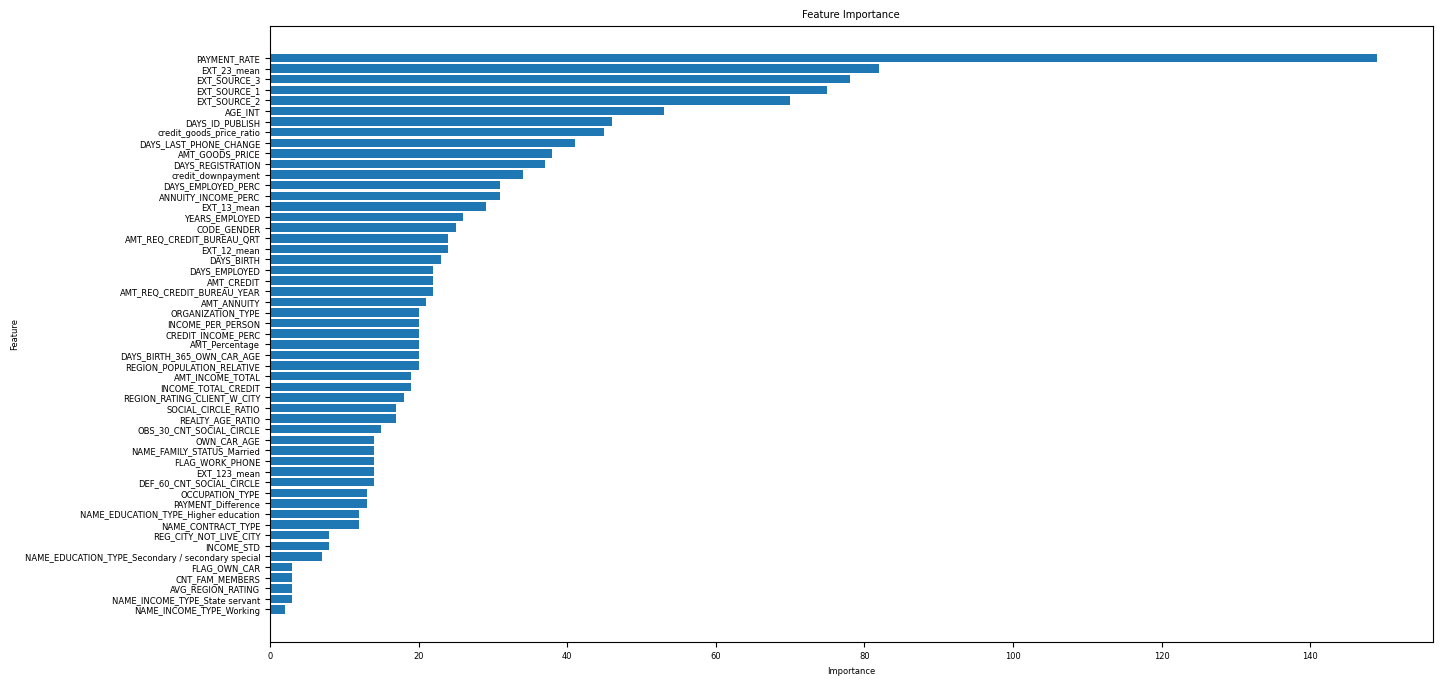

In [102]:
importance = lgb.feature_importances_
feature_names = columns
for feature, imp in zip(feature_names, importance):
    print(f"Feature: {feature}, Importance: {imp}")

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.rcParams["font.size"] = 6
plt.figure(figsize=(15, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


In [103]:

for feature, imp in zip(feature_names, importance):
    if imp==0:

        print(feature)

In [35]:
print(df_["NAME_HOUSING_TYPE"].unique())

['House / apartment' 'With parents' 'Rented apartment'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']


# "NAME_INCOME_TYPE"
'Working' 'State servant'  


['Pensioner','Commercial associate','Student','Businessman','Maternity leave','Unemployed']

# "NAME_EDUCATION_TYPE"
'Higher education' 'Secondary / secondary special' 'Academic degree'

['Lower secondary','Incomplete higher'] 

'House / apartment','With parents','Rented apartment','Office apartment' 

 ['Co-op apartment','Municipal apartment'] 

In [31]:
import lightgbm

In [45]:
from sklearn.metrics import accuracy_score

In [124]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    Taccuracy = accuracy_score(y_train, y_pred_train)
    accuracy = accuracy_score(y_test, y_pred)
    print(Taccuracy)
    print(accuracy)
    return accuracy

In [127]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)


[I 2024-07-01 14:31:15,525] A new study created in memory with name: no-name-9f0f1d75-2ab9-4aba-bb06-7854070319ae
[I 2024-07-01 14:31:18,326] Trial 0 finished with value: 0.9182266873046933 and parameters: {'lambda_l1': 1.2744177338425787e-06, 'lambda_l2': 0.01057772639779298, 'num_leaves': 219, 'learning_rate': 0.0036376045252784774, 'feature_fraction': 0.4272196801313898, 'bagging_fraction': 0.6168347405124837, 'bagging_freq': 2, 'min_child_samples': 39}. Best is trial 0 with value: 0.9182266873046933.


0.9195318375303919
0.9182266873046933


[I 2024-07-01 14:31:20,709] Trial 1 finished with value: 0.9182266873046933 and parameters: {'lambda_l1': 0.00013588680409242485, 'lambda_l2': 1.603833335468405e-07, 'num_leaves': 227, 'learning_rate': 0.00038902252983158674, 'feature_fraction': 0.5442024222209147, 'bagging_fraction': 0.5343211840435074, 'bagging_freq': 5, 'min_child_samples': 35}. Best is trial 0 with value: 0.9182266873046933.


0.9195318375303919
0.9182266873046933


[I 2024-07-01 14:31:22,914] Trial 2 finished with value: 0.9090563943810053 and parameters: {'lambda_l1': 3.096279592095304e-06, 'lambda_l2': 1.9353922104344425, 'num_leaves': 208, 'learning_rate': 0.5176244792251259, 'feature_fraction': 0.6322731159188595, 'bagging_fraction': 0.9575971593845715, 'bagging_freq': 1, 'min_child_samples': 87}. Best is trial 0 with value: 0.9182266873046933.


0.9972619942903455
0.9090563943810053


[I 2024-07-01 14:31:25,498] Trial 3 finished with value: 0.9152185975876873 and parameters: {'lambda_l1': 0.0005030087968064239, 'lambda_l2': 2.0724448287914133e-08, 'num_leaves': 213, 'learning_rate': 0.17542127811563574, 'feature_fraction': 0.8983925904964667, 'bagging_fraction': 0.9094933498723157, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 0 with value: 0.9182266873046933.


0.9687794335613787
0.9152185975876873


[I 2024-07-01 14:31:27,996] Trial 4 finished with value: 0.9182266873046933 and parameters: {'lambda_l1': 0.008452663946623879, 'lambda_l2': 9.0998426160676e-06, 'num_leaves': 223, 'learning_rate': 0.009494221893977067, 'feature_fraction': 0.615545915026121, 'bagging_fraction': 0.8553704691586311, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 0 with value: 0.9182266873046933.


0.9195318375303919
0.9182266873046933


[I 2024-07-01 14:31:30,513] Trial 5 finished with value: 0.9182266873046933 and parameters: {'lambda_l1': 1.1971924949651032e-08, 'lambda_l2': 1.92329334855756e-06, 'num_leaves': 175, 'learning_rate': 0.00446335761850575, 'feature_fraction': 0.8745352291800652, 'bagging_fraction': 0.8180727421558701, 'bagging_freq': 4, 'min_child_samples': 23}. Best is trial 0 with value: 0.9182266873046933.


0.9195318375303919
0.9182266873046933


[I 2024-07-01 14:31:31,505] Trial 6 finished with value: 0.9182266873046933 and parameters: {'lambda_l1': 0.012833847027840024, 'lambda_l2': 0.0019162750123561602, 'num_leaves': 16, 'learning_rate': 0.0015819732911954534, 'feature_fraction': 0.9650268840558627, 'bagging_fraction': 0.5927836587355071, 'bagging_freq': 4, 'min_child_samples': 17}. Best is trial 0 with value: 0.9182266873046933.


0.9195318375303919
0.9182266873046933


[I 2024-07-01 14:31:32,854] Trial 7 finished with value: 0.9182266873046933 and parameters: {'lambda_l1': 0.011299167375877042, 'lambda_l2': 5.018230497245119e-06, 'num_leaves': 31, 'learning_rate': 0.0006117935843982891, 'feature_fraction': 0.7647586856478474, 'bagging_fraction': 0.9798771599052682, 'bagging_freq': 5, 'min_child_samples': 42}. Best is trial 0 with value: 0.9182266873046933.


0.9195318375303919
0.9182266873046933


[I 2024-07-01 14:31:34,815] Trial 8 finished with value: 0.9182266873046933 and parameters: {'lambda_l1': 2.087431026623397, 'lambda_l2': 4.767251861421642e-06, 'num_leaves': 111, 'learning_rate': 0.0035284808520393567, 'feature_fraction': 0.8525856648647261, 'bagging_fraction': 0.6253391451336141, 'bagging_freq': 3, 'min_child_samples': 24}. Best is trial 0 with value: 0.9182266873046933.


0.9195318375303919
0.9182266873046933


[I 2024-07-01 14:31:37,424] Trial 9 finished with value: 0.9186063491136357 and parameters: {'lambda_l1': 0.04710505479025948, 'lambda_l2': 0.3525136736597504, 'num_leaves': 240, 'learning_rate': 0.06182882154242146, 'feature_fraction': 0.41938038740074823, 'bagging_fraction': 0.7597164690300999, 'bagging_freq': 4, 'min_child_samples': 82}. Best is trial 9 with value: 0.9186063491136357.


0.9266506523754937
0.9186063491136357


[I 2024-07-01 14:31:39,418] Trial 10 finished with value: 0.9186647586227038 and parameters: {'lambda_l1': 2.414661043687655, 'lambda_l2': 4.946929767894499, 'num_leaves': 105, 'learning_rate': 0.0639615366952364, 'feature_fraction': 0.43812546813580666, 'bagging_fraction': 0.7397614905477087, 'bagging_freq': 7, 'min_child_samples': 100}. Best is trial 10 with value: 0.9186647586227038.


0.9216784340067611
0.9186647586227038


[I 2024-07-01 14:31:41,273] Trial 11 finished with value: 0.9184895300954995 and parameters: {'lambda_l1': 1.8854766925586197, 'lambda_l2': 4.135093794278163, 'num_leaves': 99, 'learning_rate': 0.053560364753342256, 'feature_fraction': 0.4070376854942225, 'bagging_fraction': 0.7442446196833906, 'bagging_freq': 7, 'min_child_samples': 100}. Best is trial 10 with value: 0.9186647586227038.


0.921123531516271
0.9184895300954995


[I 2024-07-01 14:31:43,290] Trial 12 finished with value: 0.9187815776408399 and parameters: {'lambda_l1': 0.2480812276893893, 'lambda_l2': 0.06229510012631236, 'num_leaves': 153, 'learning_rate': 0.04939646948475014, 'feature_fraction': 0.49288345833902386, 'bagging_fraction': 0.4180299232687016, 'bagging_freq': 7, 'min_child_samples': 80}. Best is trial 12 with value: 0.9187815776408399.


0.9228393484276546
0.9187815776408399


[I 2024-07-01 14:31:45,239] Trial 13 finished with value: 0.9181390730410911 and parameters: {'lambda_l1': 9.106090696348517, 'lambda_l2': 0.057007277451997816, 'num_leaves': 144, 'learning_rate': 0.026637696255622196, 'feature_fraction': 0.5200540615382486, 'bagging_fraction': 0.4380739563006955, 'bagging_freq': 7, 'min_child_samples': 64}. Best is trial 12 with value: 0.9187815776408399.


0.9195975496674236
0.9181390730410911


[I 2024-07-01 14:31:46,619] Trial 14 finished with value: 0.9182266873046933 and parameters: {'lambda_l1': 0.26431290630299153, 'lambda_l2': 0.00019258128317404746, 'num_leaves': 64, 'learning_rate': 0.0001010464164718481, 'feature_fraction': 0.5203083506112475, 'bagging_fraction': 0.4375586069451549, 'bagging_freq': 6, 'min_child_samples': 95}. Best is trial 12 with value: 0.9187815776408399.


0.9195318375303919
0.9182266873046933


[I 2024-07-01 14:31:48,929] Trial 15 finished with value: 0.9043252241464911 and parameters: {'lambda_l1': 0.35510416197854355, 'lambda_l2': 0.11282122015609054, 'num_leaves': 154, 'learning_rate': 0.3425195621515669, 'feature_fraction': 0.7183781201740601, 'bagging_fraction': 0.51603491767198, 'bagging_freq': 7, 'min_child_samples': 75}. Best is trial 12 with value: 0.9187815776408399.


0.9649389242193033
0.9043252241464911


[I 2024-07-01 14:31:50,714] Trial 16 finished with value: 0.918080663532023 and parameters: {'lambda_l1': 7.627148459505429e-05, 'lambda_l2': 6.317373176578303, 'num_leaves': 79, 'learning_rate': 0.11180918160247563, 'feature_fraction': 0.48622920670754777, 'bagging_fraction': 0.7041778635761236, 'bagging_freq': 6, 'min_child_samples': 71}. Best is trial 12 with value: 0.9187815776408399.


0.9232117172041676
0.918080663532023


[I 2024-07-01 14:31:52,769] Trial 17 finished with value: 0.8554072603019771 and parameters: {'lambda_l1': 0.0013627258623574547, 'lambda_l2': 0.00028982998002389176, 'num_leaves': 179, 'learning_rate': 0.966701656834671, 'feature_fraction': 0.6206390750150523, 'bagging_fraction': 0.6721000654222793, 'bagging_freq': 7, 'min_child_samples': 88}. Best is trial 12 with value: 0.9187815776408399.


0.8956929344849994
0.8554072603019771


[I 2024-07-01 14:31:55,026] Trial 18 finished with value: 0.9182266873046933 and parameters: {'lambda_l1': 0.21592898099282545, 'lambda_l2': 0.43441905525076846, 'num_leaves': 123, 'learning_rate': 0.01895132009519377, 'feature_fraction': 0.56145365892155, 'bagging_fraction': 0.8042653106615409, 'bagging_freq': 5, 'min_child_samples': 54}. Best is trial 12 with value: 0.9187815776408399.


0.9196924671986916
0.9182266873046933


[I 2024-07-01 14:31:56,318] Trial 19 finished with value: 0.9182266873046933 and parameters: {'lambda_l1': 9.224421837944144, 'lambda_l2': 0.013347730076559376, 'num_leaves': 49, 'learning_rate': 0.021805620773658555, 'feature_fraction': 0.4896187445963093, 'bagging_fraction': 0.40042362014411215, 'bagging_freq': 6, 'min_child_samples': 80}. Best is trial 12 with value: 0.9187815776408399.


0.9195318375303919
0.9182266873046933


In [31]:
print('Best trial:')
trial = study.best_trial
print('Accuracy:', trial.value)
print("Best hyperparameters:", trial.params)


Best trial:
Accuracy: 0.9186647586227038
Best hyperparameters: {'lambda_l1': 0.00035240278276659967, 'lambda_l2': 3.3602464271941526, 'num_leaves': 84, 'learning_rate': 0.05337961575790194, 'feature_fraction': 0.539258644115885, 'bagging_fraction': 0.7243925148353267, 'bagging_freq': 4, 'min_child_samples': 23}


In [105]:

pred2 = xgb.predict_proba(Test_X)[:, 1]

In [106]:
pred2

array([0.03305323, 0.17087871, 0.14144526, ..., 0.03088835, 0.12699345,
       0.04986493], dtype=float32)

In [104]:
pred = lgb.predict_proba(Test_X)[:, 1]
pred2 = xgb.predict_proba(Test_X)[:, 1]
pred = (pred+pred2)/2
sample_sub['TARGET'] = pred
sample_sub

SK_ID_CURR    TARGET
0          171202  0.036710
1          171203  0.176547
2          171204  0.141837
3          171205  0.078796
4          171206  0.189606
...           ...       ...
61495      232697  0.130400
61496      232698  0.034758
61497      232699  0.047216
61498      232700  0.136912
61499      232701  0.080387

[61500 rows x 2 columns]

In [107]:
sample_sub.to_csv("mix2.csv", index=False)


# ORGANIZATION_TYPE

# site

https://toshikishimizu.hatenablog.com/entry/2018/09/16/113851#%E3%82%B3%E3%83%B3%E3%83%9A%E3%81%AE%E6%A6%82%E8%A6%81

https://data-analysis-stats.jp/kaggle/kaggle1%e4%bd%8d%e3%81%ae%e8%a7%a3%e6%9e%90%e6%89%8b%e6%b3%95%e3%80%80%e3%80%8chome-credit-default-risk-%e5%82%b5%e5%8b%99%e4%b8%8d%e5%b1%a5%e8%a1%8c%e3%81%ae%e4%ba%88%e6%b8%ac%e3%80%8d%e2%91%a1/

https://www.kaggle.com/code/ogrellier/good-fun-with-ligthgbm

In [ ]:
# heatmap
#smote
#parameter tuning